프로젝트 샘플
http://naver.me/50oquHxy

# 여성 의류 사이즈 기준 및 상품 추천 시스템 모델 개발

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import selenium
import requests

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from urllib import request
from urllib.request import urlopen, urlretrieve
from urllib.parse import quote_plus

## 1) 원피스 전체 (미니, 미디, 멕시 원피스) 크롤링 1~10page, 상품 치수만 출력

### ① 1~10페이지 내의 상품 접속 '링크만' 추출

In [3]:
#1~10페이지 내의 상품 접속 '링크만' 추출
#soup.select(selector= '#searchList > li:nth-child(1) > div.li_inner > div.article_info > p.list_info > a')

dresses = []

for i in range(1, 11):
    url = f'https://www.musinsa.com/categories/item/020?d_cat_cd=020&brand=&list_kind=small&sort=sale_high&sub_sort=3m&page={i}&display_cnt=90&group_sale=&exclusive_yn=&sale_goods=&timesale_yn=&ex_soldout=&kids=&color=&price1=&price2=&shoeSizeOption=&tags=&campaign_id=&includeKeywords=&measure='
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html.parser')
    #사이트 내 상품명 & 링크
    products = soup.select(selector = 'p.list_info > a')
    
    #링크만 추출
    for product in products:
        dresses.append(product['href'])

dress_links = []

#링크 모음 리스트 dresses 내에 있는 링크에 대한 조건문
for dress in dresses:
    if 'http:' in dress:
        pass
    elif 'https:' in dress:
        pass
    else:
        dress = 'http:' + dress
        dress_links.append(dress)
        
print(dress_links)

['http://www.musinsa.com/app/goods/2827957?loc=goods_rank', 'http://www.musinsa.com/app/goods/2714524?loc=goods_rank', 'http://www.musinsa.com/app/goods/2788583?loc=goods_rank', 'http://www.musinsa.com/app/goods/2374001?loc=goods_rank', 'http://www.musinsa.com/app/goods/1723873?loc=goods_rank', 'http://www.musinsa.com/app/goods/1683243?loc=goods_rank', 'http://www.musinsa.com/app/goods/2742440?loc=goods_rank', 'http://www.musinsa.com/app/goods/1792540?loc=goods_rank', 'http://www.musinsa.com/app/goods/1630818?loc=goods_rank', 'http://www.musinsa.com/app/goods/2429700?loc=goods_rank', 'http://www.musinsa.com/app/goods/2368991?loc=goods_rank', 'http://www.musinsa.com/app/goods/2377826?loc=goods_rank', 'http://www.musinsa.com/app/goods/2398607?loc=goods_rank', 'http://www.musinsa.com/app/goods/987370?loc=goods_rank', 'http://www.musinsa.com/app/goods/1963314?loc=goods_rank', 'http://www.musinsa.com/app/goods/2647666?loc=goods_rank', 'http://www.musinsa.com/app/goods/2587988?loc=goods_rank

In [4]:
dress_links[0]

'http://www.musinsa.com/app/goods/2827957?loc=goods_rank'

### ② 1~10페이지 내 상품들 각각의 S,M,L,XL 사이즈 출력 (수정)

In [5]:
#1~10페이지 내 상품들 각각의 S,M,L,XL 사이즈 출력 (오류 수정)
header = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}
dress_data = pd.DataFrame()

for dress_link in dress_links:
    html = requests.get(dress_link, headers = header).text
    soup = BeautifulSoup(html, 'html.parser')
    columns = soup.find_all(class_ = 'item_val')    #사이즈표의 칼럼
    size_cats = soup.select('#size_table > tbody > tr > th')    #사이즈표의 사이즈
    #size_table > tbody
    #size_table > tbody > tr:nth-child(3) > td:nth-child(2)
    
    if columns:
        #사이즈표의 칼럼명 (총장, 어깨너비, ..)
        columns_parts = [column.text.strip() for column in columns]
        #사이즈표의 사이즈명 (S, M, ..)
        size_cate = [cate.text.strip() for cate in size_cats][1:]
        
        #전체 사이즈의 전체 치수 모음 리스트
        size_val = []
        
        for i in range(3, len(size_cats) + 3):
            for j in range(2, len(columns_parts) + 2):
                types = soup.select(f'#size_table > tbody > tr:nth-child({i}) > td:nth-child({j})')
                types = re.sub('[^0-9.]', '', str(types))
                size_val.append(types.strip())
                
        size_val = [v for v in size_val if v]
        
        #각각의 상품 사이즈표 칼럼수 만큼 치수 분배
        n = len(columns_parts)    #사이즈표 칼럼수
        results = [size_val[i * n: (i+1)*n] for i in range((len(size_val) + n-1) // n)]
        colpts = columns_parts * (len(results))
        
        columns_parts = columns_parts * (int(len(size_val) / len(columns_parts)))
        
        categories = []
        
        n = int(len(size_val) / len(size_cate))
        
        for size in size_cate:
            for i in range(n):
                categories.append(size)
                
        size_val_df = pd.DataFrame(size_val)
        size_cate_df = pd.DataFrame(categories)
        columns_part_df = pd.DataFrame(columns_parts)
        
        df_1 = pd.concat([size_val_df, size_cate_df], axis=1)
        df_2 = pd.concat([df_1, columns_part_df], axis=1)
        
        dress_data = pd.concat([dress_data, df_2], axis=0)
        
    else:
        continue
        
dress_data

,0,0,0
0,128,34,총장
1,60,34,어깨너비
2,63,34,가슴단면
3,55,34,소매길이
4,129,36,총장
...,...,...,...
11,59,M,소매길이
12,123,L,총장
13,36,L,어깨너비
14,51,L,가슴단면


In [6]:
dress_data.columns = ['measures', 'size', 'columns']
dress_data['size'].value_counts()

S          1487
M          1452
FREE       1053
L           252
옵션없음        205
           ... 
단품원피스S        2
WHITE/M       2
WHITE/S       2
medium        2
NAVY          2
Name: size, Length: 157, dtype: int64

In [8]:
dress_data

,measures,size,columns
0,128,34,총장
1,60,34,어깨너비
2,63,34,가슴단면
3,55,34,소매길이
4,129,36,총장
...,...,...,...
11,59,M,소매길이
12,123,L,총장
13,36,L,어깨너비
14,51,L,가슴단면


In [9]:
dress_data.to_csv('C:/Users/admin/#실습(221031~221111)/dress_data.csv')

## 2) 무신사 내 상품 사이즈의 S, M, L, XL 치수의 평균값 (파이차트 시각화)

In [11]:
dress_data = pd.read_csv('C:/Users/admin/#실습(221031~221111)/dress_data.csv').iloc[:, 1:]
dress_data

,measures,size,columns
0,128.0,34,총장
1,60.0,34,어깨너비
2,63.0,34,가슴단면
3,55.0,34,소매길이
4,129.0,36,총장
...,...,...,...
6646,59.0,M,소매길이
6647,123.0,L,총장
6648,36.0,L,어깨너비
6649,51.0,L,가슴단면


In [12]:
dress_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6651 entries, 0 to 6650
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   measures  6651 non-null   float64
 1   size      6650 non-null   object 
 2   columns   6648 non-null   object 
dtypes: float64(1), object(2)
memory usage: 156.0+ KB


### * 결측치 제거

In [13]:
dress_data.isnull().sum()

measures    0
size        1
columns     3
dtype: int64

In [14]:
dress_data.dropna(axis=0, inplace=True)

In [15]:
dress_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6648 entries, 0 to 6650
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   measures  6648 non-null   float64
 1   size      6648 non-null   object 
 2   columns   6648 non-null   object 
dtypes: float64(1), object(2)
memory usage: 207.8+ KB


In [16]:
dress_data.reset_index(inplace=True)
dress_data

,index,measures,size,columns
0,0,128.0,34,총장
1,1,60.0,34,어깨너비
2,2,63.0,34,가슴단면
3,3,55.0,34,소매길이
4,4,129.0,36,총장
...,...,...,...,...
6643,6646,59.0,M,소매길이
6644,6647,123.0,L,총장
6645,6648,36.0,L,어깨너비
6646,6649,51.0,L,가슴단면


In [17]:
dress_data = dress_data.iloc[:, 1:]
dress_data

,measures,size,columns
0,128.0,34,총장
1,60.0,34,어깨너비
2,63.0,34,가슴단면
3,55.0,34,소매길이
4,129.0,36,총장
...,...,...,...
6643,59.0,M,소매길이
6644,123.0,L,총장
6645,36.0,L,어깨너비
6646,51.0,L,가슴단면


### ① 의미없는 사이즈 표기 제외

In [18]:
dress_data['size'].unique()

array(['34', '36', '38', 'FREE', 'S', 'M', 'free', 'S SIZE', 'M SIZE',
       '옵션없음', '1(S)', '2(M)', 'XS', 'L', '(S~M)', '(L~XL)', 'OS', '1',
       '2', 'BLACK_FREE', 'BLACK', '085', '088', '091', '1 SIZE',
       '2 SIZE', 'S_085', 'M_090', 'S[085]', 'M[090]', 'F',
       'ONEPIECE BLACK:1', 'ONEPIECE BLACK:2', 'Free', 'medium', 'XL',
       '100', '110', '120', '130', '140', '150', '프리사이즈', '92cm (1.5-2y)',
       '98cm (2-3y)', '104cm (3-4y)', '110cm (4-5y)', '116cm (5-6y)',
       '122cm (6-7y)', '00S', '00M', '네이비', 's size', 'm size', 'S-Long',
       'ONE SIZE', '85', '88', '91', '9M', '12M', '18M', '24M', 'S(55)',
       'M(66)', '55', '66', '77', 'S_PURPLE', 'ONE', '0', '090', '095',
       'XS55', 'S66', 'M77', '38(55)', '40(66)', 'XS_85', 'S_90', 'M_088',
       'L_091', 'WHITE/S', 'WHITE/M', 'Free / Beige', 'Free / Black',
       '네이비 M', '네이비 L', '화이트 M', '화이트 L', '01S', '02M', 'L[095]', '프리',
       '단품원피스S', '단품원피스M', '단품원피스L', 'm', 's', '옐로우 M', '옐로우 L',
       'charc

In [19]:
drop_size_columns = ['34', '36', '38', '(S~M)', '(L~XL)', '1', '2', 'BLACK', '085', '088', '091',
                     '1 SIZE', '2 SIZE', 'ONEPIECE BLACK:1', 'ONEPIECE BLACK:2',
                     '100', '110', '120', '130', '140', '150', '92cm (1.5-2y)', '98cm (2-3y)',
                     '104cm (3-4y)', '110cm (4-5y)', '116cm (5-6y)', '122cm (6-7y)', '네이비',
                     '85', '88', '91', '9M', '12M', '18M', '24M', '55', '66', '77', '0', '090', '095',
                     '38(55)', '40(66)', 'charcoal', '1-2세(86-92cm)', '2-3세(92-98cm)', '3-4세(98-104cm)',
                     '4-5세(104-110cm)', '5-6세(110-116cm)', '7-8세(122-128cm)', '40', '90', 'XXS', '55(85)', '66(90)', '77(95)',
                     '88(100)', 'SM', 'Short', 'Long', '3T', '5T', '7T', '9T', '080', '8', '10', '12', '14', '16',
                     'blue', '145', '04', '06', '07', '08', '11T', '4', '6', '95', '3(L)', 'NAVY']

drop_index = []

for i in range(len(dress_data['size'])):
    if dress_data['size'][i] in drop_size_columns:
        drop_index.append(i)
        #print(dress_data.drop(dress_data.iloc[i, :], axis=0))
    else:
        continue

dress_data.drop(drop_index, inplace=True)

#print('drop_index:', drop_index)
#print()
print('unique:', dress_data['size'].unique())

unique: ['FREE' 'S' 'M' 'free' 'S SIZE' 'M SIZE' '옵션없음' '1(S)' '2(M)' 'XS' 'L'
 'OS' 'BLACK_FREE' 'S_085' 'M_090' 'S[085]' 'M[090]' 'F' 'Free' 'medium'
 'XL' '프리사이즈' '00S' '00M' 's size' 'm size' 'S-Long' 'ONE SIZE' 'S(55)'
 'M(66)' 'S_PURPLE' 'ONE' 'XS55' 'S66' 'M77' 'XS_85' 'S_90' 'M_088'
 'L_091' 'WHITE/S' 'WHITE/M' 'Free / Beige' 'Free / Black' '네이비 M' '네이비 L'
 '화이트 M' '화이트 L' '01S' '02M' 'L[095]' '프리' '단품원피스S' '단품원피스M' '단품원피스L' 'm'
 's' '옐로우 M' '옐로우 L' '1ONE SIZE' 'SMALL' 'MEDIUM' 'XS(55)' 'S(66)' 'M(77)'
 'S(36)' 'M(38)' 'FF(FREE)' 'S(85)' 'M(90)' 'FRE' 'BLACK-FREE' 'black / F'
 'One size' 'S(085)' 'M(088)']


In [ ]:
#mini_dress_data.isin(drop_size_columns).sum()
#mini_dress_data[mini_dress_data['size'] in drop_size_columns]

In [20]:
dress_data = dress_data.reset_index().iloc[:, 1:]
dress_data

,measures,size,columns
0,82.0,FREE,총장
1,42.0,FREE,어깨너비
2,50.0,FREE,가슴단면
3,62.0,FREE,소매길이
4,121.0,S,총장
...,...,...,...
5506,59.0,M,소매길이
5507,123.0,L,총장
5508,36.0,L,어깨너비
5509,51.0,L,가슴단면


### ② 사이즈 표기 통일 (FREE, XS, S, M, L, XL)

In [21]:
dress_data['size'].unique()

array(['FREE', 'S', 'M', 'free', 'S SIZE', 'M SIZE', '옵션없음', '1(S)',
       '2(M)', 'XS', 'L', 'OS', 'BLACK_FREE', 'S_085', 'M_090', 'S[085]',
       'M[090]', 'F', 'Free', 'medium', 'XL', '프리사이즈', '00S', '00M',
       's size', 'm size', 'S-Long', 'ONE SIZE', 'S(55)', 'M(66)',
       'S_PURPLE', 'ONE', 'XS55', 'S66', 'M77', 'XS_85', 'S_90', 'M_088',
       'L_091', 'WHITE/S', 'WHITE/M', 'Free / Beige', 'Free / Black',
       '네이비 M', '네이비 L', '화이트 M', '화이트 L', '01S', '02M', 'L[095]', '프리',
       '단품원피스S', '단품원피스M', '단품원피스L', 'm', 's', '옐로우 M', '옐로우 L',
       '1ONE SIZE', 'SMALL', 'MEDIUM', 'XS(55)', 'S(66)', 'M(77)',
       'S(36)', 'M(38)', 'FF(FREE)', 'S(85)', 'M(90)', 'FRE',
       'BLACK-FREE', 'black / F', 'One size', 'S(085)', 'M(088)'],
      dtype=object)

In [22]:
print(dress_data['size'].iloc[0])
print(dress_data['size'].iloc[0].replace(dress_data['size'].iloc[0], 'Free'))

FREE
Free


#### * size 표기를 모두 대문자로 변경

In [23]:
for i in range(len(dress_data['size'])):
    dress_data['size'].iloc[i] = dress_data['size'].iloc[i].upper()

print(dress_data['size'].unique())

['FREE' 'S' 'M' 'S SIZE' 'M SIZE' '옵션없음' '1(S)' '2(M)' 'XS' 'L' 'OS'
 'BLACK_FREE' 'S_085' 'M_090' 'S[085]' 'M[090]' 'F' 'MEDIUM' 'XL' '프리사이즈'
 '00S' '00M' 'S-LONG' 'ONE SIZE' 'S(55)' 'M(66)' 'S_PURPLE' 'ONE' 'XS55'
 'S66' 'M77' 'XS_85' 'S_90' 'M_088' 'L_091' 'WHITE/S' 'WHITE/M'
 'FREE / BEIGE' 'FREE / BLACK' '네이비 M' '네이비 L' '화이트 M' '화이트 L' '01S' '02M'
 'L[095]' '프리' '단품원피스S' '단품원피스M' '단품원피스L' '옐로우 M' '옐로우 L' '1ONE SIZE'
 'SMALL' 'XS(55)' 'S(66)' 'M(77)' 'S(36)' 'M(38)' 'FF(FREE)' 'S(85)'
 'M(90)' 'FRE' 'BLACK-FREE' 'BLACK / F' 'S(085)' 'M(088)']


#### * 사이즈 표기 통일 (Free, XS, S, M, L, XL)

In [24]:
#re.sub(".+123.+", "#", string)
#re.search("L.*", mini_dress_data['size'].iloc[i])
for i in range(len(dress_data['size'])):
    if re.search("F.*", dress_data['size'].iloc[i]):
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif 'ONE' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif 'OS' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif '프리' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif '옵션없음' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'Free')
        
    elif 'XS' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'XS')
        
    elif re.search("M.*", dress_data['size'].iloc[i]):
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'M')
    
    elif re.search("S.*", dress_data['size'].iloc[i]):
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'S')
        
    elif 'XL' in dress_data['size'].iloc[i]:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'XL')
        
    else:
        dress_data['size'].iloc[i] = dress_data['size'].iloc[i].replace(dress_data['size'].iloc[i], 'L')

In [25]:
dress_data['size'].unique()

array(['Free', 'S', 'M', 'XS', 'L', 'XL'], dtype=object)

### ③ 사이즈별 치수의 평균값 (총장, 어깨너비, 가슴단면, 소매길이)

In [26]:
dress_data.groupby(['columns', 'size'])[['measures']].mean().round(3)

measures
columns size          
가슴단면    Free    47.301
        L       48.047
        M       46.411
        S       44.193
        XL      51.500
        XS      42.482
밑단단면    Free    28.000
        L       60.500
        M       53.094
        S       50.143
        XL      63.000
밑위      Free    34.000
소매길이    Free    53.025
        L       29.199
        M       39.998
        S       40.119
        XL      19.429
        XS      38.153
어깨너비    Free    41.383
        L       39.155
        M       40.361
        S       39.000
        XL      44.714
        XS      38.905
엉덩이단면   Free    53.664
        L       48.900
        M       50.275
        S       48.239
        XL      52.000
        XS      34.250
총장      Free    94.648
        L       97.710
        M       90.751
        S       88.894
        XL      94.500
        XS      87.778
허리단면    Free    32.000
        L       41.000
        M       41.344
        S       39.357
        XL      43.500
허벅지단면   Free    27.000

In [27]:
dress_XS = dress_data.query("size == 'XS'")
dress_S = dress_data.query("size == 'S'")
dress_M = dress_data.query("size == 'M'")
dress_Free = dress_data.query("size == 'Free'")
dress_L = dress_data.query("size == 'L'")
dress_XL = dress_data.query("size == 'XL'")

#총장
print('XS_총장:', np.round(dress_XS.query("columns == '총장'")['measures'].mean(), 3))
print('S_총장:', np.round(dress_S.query("columns == '총장'")['measures'].mean(), 3))
print('M_총장:', np.round(dress_M.query("columns == '총장'")['measures'].mean(), 3))
print('Free_총장:', np.round(dress_Free.query("columns == '총장'")['measures'].mean(), 3))
print('L_총장:', np.round(dress_L.query("columns == '총장'")['measures'].mean(), 3))
print('XL_총장:', np.round(dress_XL.query("columns == '총장'")['measures'].mean(), 3))
print()

#어깨너비
print('XS_어깨너비:', np.round(dress_XS.query("columns == '어깨너비'")['measures'].mean(), 3))
print('S_어깨너비:', np.round(dress_S.query("columns == '어깨너비'")['measures'].mean(), 3))
print('M_어깨너비:', np.round(dress_M.query("columns == '어깨너비'")['measures'].mean(), 3))
print('Free_어깨너비:', np.round(dress_Free.query("columns == '어깨너비'")['measures'].mean(), 3))
print('L_어깨너비:', np.round(dress_L.query("columns == '어깨너비'")['measures'].mean(), 3))
print('XL_어깨너비:', np.round(dress_XL.query("columns == '어깨너비'")['measures'].mean(), 3))
print()

#가슴단면
print('XS_가슴단면:', np.round(dress_XS.query("columns == '가슴단면'")['measures'].mean(), 3))
print('S_가슴단면:', np.round(dress_S.query("columns == '가슴단면'")['measures'].mean(), 3))
print('M_가슴단면:', np.round(dress_M.query("columns == '가슴단면'")['measures'].mean(), 3))
print('Free_가슴단면:', np.round(dress_Free.query("columns == '가슴단면'")['measures'].mean(), 3))
print('L_가슴단면:', np.round(dress_L.query("columns == '가슴단면'")['measures'].mean(), 3))
print('XL_가슴단면:', np.round(dress_XL.query("columns == '가슴단면'")['measures'].mean(), 3))
print()

#소매길이
print('XS_소매길이:', np.round(dress_XS.query("columns == '소매길이'")['measures'].mean(), 3))
print('S_소매길이:', np.round(dress_S.query("columns == '소매길이'")['measures'].mean(), 3))
print('M_소매길이:', np.round(dress_M.query("columns == '소매길이'")['measures'].mean(), 3))
print('Free_소매길이:', np.round(dress_Free.query("columns == '소매길이'")['measures'].mean(), 3))
print('L_소매길이:', np.round(dress_L.query("columns == '소매길이'")['measures'].mean(), 3))
print('XL_소매길이:', np.round(dress_XL.query("columns == '소매길이'")['measures'].mean(), 3))

XS_총장: 87.778
S_총장: 88.894
M_총장: 90.751
Free_총장: 94.648
L_총장: 97.71
XL_총장: 94.5

XS_어깨너비: 38.905
S_어깨너비: 39.0
M_어깨너비: 40.361
Free_어깨너비: 41.383
L_어깨너비: 39.155
XL_어깨너비: 44.714

XS_가슴단면: 42.482
S_가슴단면: 44.193
M_가슴단면: 46.411
Free_가슴단면: 47.301
L_가슴단면: 48.047
XL_가슴단면: 51.5

XS_소매길이: 38.153
S_소매길이: 40.119
M_소매길이: 39.998
Free_소매길이: 53.025
L_소매길이: 29.199
XL_소매길이: 19.429


### ④ 사이즈 코리아 데이터

In [28]:
dt_2020 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/사이즈코리아/2020_size_measures.csv").query("성별 == '여'")
dt_2020

,Unnamed: 0,HUMAN_ID,성별,조사년도,조사일,나이,측정지,측정복\n젖가슴둘레,측정복\n상의,측정복\n배꼽수준허리둘레,...,128. 배꼽수준앞중심길이,129. 배꼽수준등길이,130. 목뒤젖꼭지길이,131. 목뒤젖꼭지허리둘레선길이,132. 배꼽수준샅앞뒤길이,133. 앉은눈높이,134. 앉은목뒤높이,135. 앉은어깨높이,136. 앉은팔꿈치높이(팔굽힌),137. 위팔수직길이(팔굽힌)
3,4,20_F_1465,여,2020,1116,42,서울/경기/강원,86.0,85XL,88.0,...,449,453.0,356.5,546.5,882,796,659,626.0,294.0,332.0
4,5,20_F_1467,여,2020,1116,42,서울/경기/강원,73.6,75M,74.5,...,360,391.0,331.5,477.5,731,738,592,544.0,234.0,310.0
5,6,20_F_1477,여,2020,1116,40,서울/경기/강원,74.3,75M,77.0,...,372,405.0,326.5,488.5,749,738,601,552.0,203.0,349.0
6,7,20_F_1486,여,2020,1117,43,서울/경기/강원,77.5,80L,78.0,...,434,428.0,331.5,517.5,741,753,611,581.0,268.0,313.0
7,8,20_F_1490,여,2020,1117,40,서울/경기/강원,80.0,80L,80.0,...,405,415.0,333.5,527.5,696,716,578,544.0,245.0,299.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5069,5070,21_F_7275,여,2021,924,27,경상권,82.0,85.0,81.0,...,390,448.0,319.5,483.5,753,767,636,575.0,269.0,306.0
5070,5071,21_F_7276,여,2021,924,34,경상권,79.0,80.0,77.0,...,349,396.0,328.0,460.0,640,723,579,529.0,248.0,281.0
5071,5072,21_F_7277,여,2021,924,32,경상권,97.0,95.0,87.0,...,428,440.0,367.5,547.5,760,774,634,589.0,259.0,330.0
5082,5083,21_F_7288,여,2021,924,31,경상권,91.0,80.0,81.0,...,410,450.0,366.5,506.5,784,729,620,568.0,244.0,324.0


In [29]:
dt_2020.loc[:, ['002. 키 ', '018. 가슴너비 ', '041. 가슴둘레 ']]

,002. 키,018. 가슴너비,041. 가슴둘레
3,1685,309,993
4,1602,263,818
5,1642,263,839
6,1589,276,867
7,1531,280,902
...,...,...,...
5069,1597,295,832
5070,1548,283,789
5071,1645,289,942
5082,1635,284,868


In [30]:
dt_2020['041. 가슴둘레/2 '] = dt_2020['041. 가슴둘레 '] * 0.5
dt_2020.loc[:, ['002. 키 ', '018. 가슴너비 ', '041. 가슴둘레/2 ']]

,002. 키,018. 가슴너비,041. 가슴둘레/2
3,1685,309,496.5
4,1602,263,409.0
5,1642,263,419.5
6,1589,276,433.5
7,1531,280,451.0
...,...,...,...
5069,1597,295,416.0
5070,1548,283,394.5
5071,1645,289,471.0
5082,1635,284,434.0


In [31]:
dt_2020['가슴단면'] = dt_2020['041. 가슴둘레/2 '] * 0.1
dt_2020['키'] = dt_2020['002. 키 '] * 0.1

dt_chest_2020 = dt_2020.loc[:, ['나이', '키', '가슴단면']]
dt_chest_2020

,나이,키,가슴단면
3,42,168.5,49.65
4,42,160.2,40.90
5,40,164.2,41.95
6,43,158.9,43.35
7,40,153.1,45.10
...,...,...,...
5069,27,159.7,41.60
5070,34,154.8,39.45
5071,32,164.5,47.10
5082,31,163.5,43.40


In [32]:
dt_chest_2020 = dt_chest_2020.sort_values(by='나이').reset_index().iloc[:, 1:]
dt_chest_2020

,나이,키,가슴단면
0,20,162.4,40.20
1,20,165.3,48.95
2,20,168.5,43.20
3,20,158.6,44.50
4,20,156.1,43.25
...,...,...,...
2768,69,170.0,43.75
2769,69,156.0,50.00
2770,69,153.8,46.35
2771,69,153.1,48.85


In [33]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

<AxesSubplot:xlabel='가슴단면', ylabel='Density'>

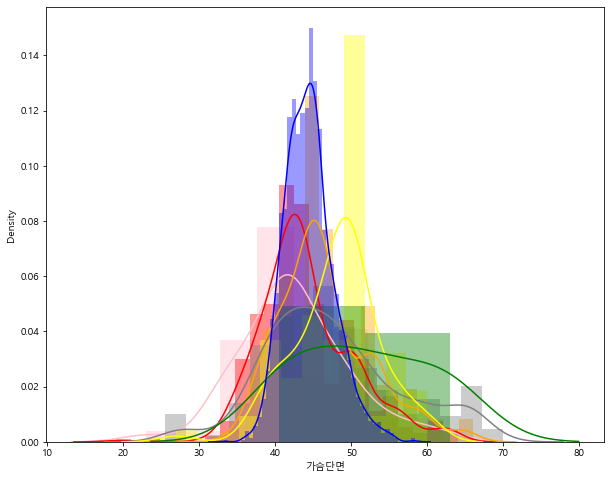

In [34]:
fig, ax = plt.subplots(figsize=(10,8))

sns.distplot(dress_XS.query("columns == '가슴단면'")['measures'], color='pink')
sns.distplot(dress_S.query("columns == '가슴단면'")['measures'], color='red')
sns.distplot(dress_M.query("columns == '가슴단면'")['measures'], color='orange')
sns.distplot(dress_Free.query("columns == '가슴단면'")['measures'], color='gray')
sns.distplot(dress_L.query("columns == '가슴단면'")['measures'], color='yellow')
sns.distplot(dress_XL.query("columns == '가슴단면'")['measures'], color='green')
sns.distplot(dt_chest_2020['가슴단면'], color='blue')

#plt.savefig('mini_dress_total_length.png')

### ⑤ pie chart (무신사 사이즈 평균값을 기준으로 사이즈 코리아 데이터를 나눔)

In [35]:
print('XS_가슴단면:', np.round(dress_XS.query("columns == '가슴단면'")['measures'].mean(), 2))
print('S_가슴단면:', np.round(dress_S.query("columns == '가슴단면'")['measures'].mean(), 2))
print('M_가슴단면:', np.round(dress_M.query("columns == '가슴단면'")['measures'].mean(), 2))
print('Free_가슴단면:', np.round(dress_Free.query("columns == '가슴단면'")['measures'].mean(), 2))
print('L_가슴단면:', np.round(dress_L.query("columns == '가슴단면'")['measures'].mean(), 2))
print('XL_가슴단면:', np.round(dress_XL.query("columns == '가슴단면'")['measures'].mean(), 2))

XS_가슴단면: 42.48
S_가슴단면: 44.19
M_가슴단면: 46.41
Free_가슴단면: 47.3
L_가슴단면: 48.05
XL_가슴단면: 51.5


In [36]:
dt_chest_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   나이      2773 non-null   int64  
 1   키       2773 non-null   float64
 2   가슴단면    2773 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 65.1 KB


In [37]:
chest_data = list(np.array(dt_chest_2020['가슴단면']))
chest_data

[40.2,
 48.95,
 43.2,
 44.5,
 43.25,
 44.5,
 42.650000000000006,
 39.150000000000006,
 45.1,
 54.650000000000006,
 50.150000000000006,
 42.0,
 39.25,
 40.0,
 48.25,
 39.0,
 42.400000000000006,
 44.800000000000004,
 41.5,
 44.650000000000006,
 43.150000000000006,
 45.150000000000006,
 46.0,
 42.45,
 42.400000000000006,
 40.650000000000006,
 48.6,
 46.45,
 40.550000000000004,
 44.35,
 40.85,
 42.95,
 42.0,
 49.5,
 41.800000000000004,
 50.150000000000006,
 42.2,
 41.0,
 45.5,
 44.400000000000006,
 42.85,
 44.650000000000006,
 41.150000000000006,
 42.050000000000004,
 40.75,
 45.1,
 42.5,
 39.7,
 42.400000000000006,
 46.95,
 39.900000000000006,
 39.800000000000004,
 41.050000000000004,
 44.35,
 44.400000000000006,
 41.85,
 44.35,
 43.400000000000006,
 40.800000000000004,
 37.9,
 46.35,
 51.400000000000006,
 43.550000000000004,
 44.900000000000006,
 45.400000000000006,
 42.25,
 44.800000000000004,
 44.85,
 47.400000000000006,
 40.5,
 43.0,
 45.85,
 41.1,
 39.550000000000004,
 45.95,
 40.1,


XS_가슴단면: 42.48<br>
S_가슴단면: 44.19<br>
M_가슴단면: 46.41<br>
Free_가슴단면: 47.3<br>
L_가슴단면: 48.05<br>
XL_가슴단면: 51.5

In [38]:
#수정수정수정
dt_chest_2020['size'] = np.random.randint(2773)
size_lst = []

for chest in chest_data:
    if chest <= 42.48:
        size_lst.append('XS')
    
    elif chest <= 44.19:
        size_lst.append('S')
        
    elif chest <= 46.41:
        size_lst.append('M')
        
    elif chest <= 47.3:
        size_lst.append('Free')
        
    elif chest <= 48.05:
        size_lst.append('L')
        
    else:
        size_lst.append('XL')
        
#print(size_lst)
#print()

dt_chest_2020['size'] = size_lst

dt_chest_2020

,나이,키,가슴단면,size
0,20,162.4,40.20,XS
1,20,165.3,48.95,XL
2,20,168.5,43.20,S
3,20,158.6,44.50,M
4,20,156.1,43.25,S
...,...,...,...,...
2768,69,170.0,43.75,S
2769,69,156.0,50.00,XL
2770,69,153.8,46.35,M
2771,69,153.1,48.85,XL


In [39]:
dt_chest_2020['size'].value_counts()

XS      800
M       776
S       562
XL      357
Free    151
L       127
Name: size, dtype: int64

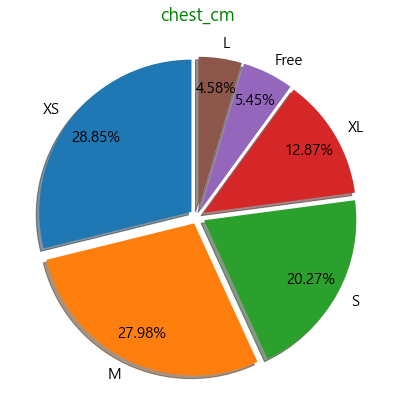

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_chest_2020['size'].value_counts(), labels=('XS', 'M', 'S', 'XL', 'Free', 'L'), startangle=90, autopct='%.2f%%',
        explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05], shadow=True, pctdistance=0.8)

# 라벨, 타이틀 달기
plt.title('chest_cm', fontsize=18, color='g')

#plt.legend(['XS', 'M', 'S', 'XL', 'Free', 'L'], loc='upper right')

plt.rc('font', size=15)

plt.show()

plt.savefig('sizekorea_chest_cm.jpg')
plt.savefig('sizekorea_chest_cm.png')

## 3) 사이즈코리아 데이터 군집화 (K-평균)
features : 키, 어깨너비, 가슴둘레, 허리둘레, 엉덩이둘레<br>
'2020_size_measures.csv' 파일은 20세 이상 성인에 대한 데이터이다<br>
002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레 ,

In [3]:
dt_2020 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/사이즈코리아/2020_size_measures.csv").query("성별 == '여'")
dt_2020[:5]

,Unnamed: 0,HUMAN_ID,성별,조사년도,조사일,나이,측정지,측정복\n젖가슴둘레,측정복\n상의,측정복\n배꼽수준허리둘레,...,128. 배꼽수준앞중심길이,129. 배꼽수준등길이,130. 목뒤젖꼭지길이,131. 목뒤젖꼭지허리둘레선길이,132. 배꼽수준샅앞뒤길이,133. 앉은눈높이,134. 앉은목뒤높이,135. 앉은어깨높이,136. 앉은팔꿈치높이(팔굽힌),137. 위팔수직길이(팔굽힌)
3,4,20_F_1465,여,2020,1116,42,서울/경기/강원,86.0,85XL,88.0,...,449,453.0,356.5,546.5,882,796,659,626.0,294.0,332.0
4,5,20_F_1467,여,2020,1116,42,서울/경기/강원,73.6,75M,74.5,...,360,391.0,331.5,477.5,731,738,592,544.0,234.0,310.0
5,6,20_F_1477,여,2020,1116,40,서울/경기/강원,74.3,75M,77.0,...,372,405.0,326.5,488.5,749,738,601,552.0,203.0,349.0
6,7,20_F_1486,여,2020,1117,43,서울/경기/강원,77.5,80L,78.0,...,434,428.0,331.5,517.5,741,753,611,581.0,268.0,313.0
7,8,20_F_1490,여,2020,1117,40,서울/경기/강원,80.0,80L,80.0,...,405,415.0,333.5,527.5,696,716,578,544.0,245.0,299.0


In [4]:
dt_2020.shape

(2773, 148)

In [5]:
#002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레
dt_2020['어깨너비'] = dt_2020.loc[:, '059. 어깨사이길이 '] * 0.1
dt_2020['가슴단면'] = dt_2020.loc[:, '041. 가슴둘레 '] * 0.05
dt_2020['엉덩이단면'] = dt_2020.loc[:, '048. 엉덩이둘레 '] * 0.05

In [6]:
dt_2020.loc[:, ['어깨너비', '가슴단면', '엉덩이단면']].reset_index()

,index,어깨너비,가슴단면,엉덩이단면
0,3,38.6,49.65,49.90
1,4,37.5,40.90,46.10
2,5,39.5,41.95,44.70
3,6,36.6,43.35,46.40
4,7,37.7,45.10,45.45
...,...,...,...,...
2768,5069,35.8,41.60,46.10
2769,5070,40.0,39.45,43.35
2770,5071,38.0,47.10,52.95
2771,5082,40.5,43.40,49.40


In [7]:
dt_2020_df = dt_2020.loc[:, ['어깨너비', '가슴단면', '엉덩이단면']].reset_index().iloc[:, 1:]
dt_2020_df

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2768,35.8,41.60,46.10
2769,40.0,39.45,43.35
2770,38.0,47.10,52.95
2771,40.5,43.40,49.40


In [8]:
dt_2020_df.describe()
dt_2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   어깨너비    2773 non-null   float64
 1   가슴단면    2773 non-null   float64
 2   엉덩이단면   2773 non-null   float64
dtypes: float64(3)
memory usage: 65.1 KB


#### 이상치 제거

In [9]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

<AxesSubplot:ylabel='어깨너비'>

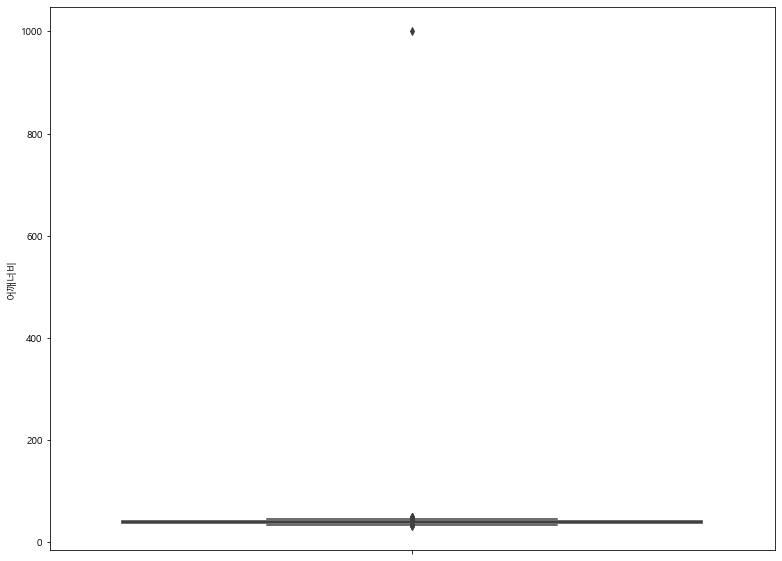

In [10]:
plt.figure(figsize=(13, 10))
sns.boxplot(data = dt_2020_df, y = '어깨너비')

<AxesSubplot:ylabel='가슴단면'>

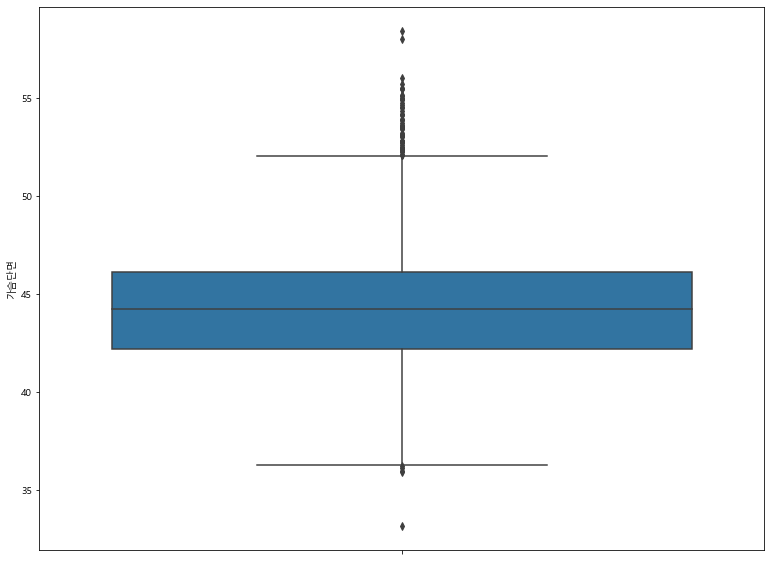

In [11]:
plt.figure(figsize=(13, 10))
sns.boxplot(data = dt_2020_df, y = '가슴단면')

<AxesSubplot:ylabel='엉덩이단면'>

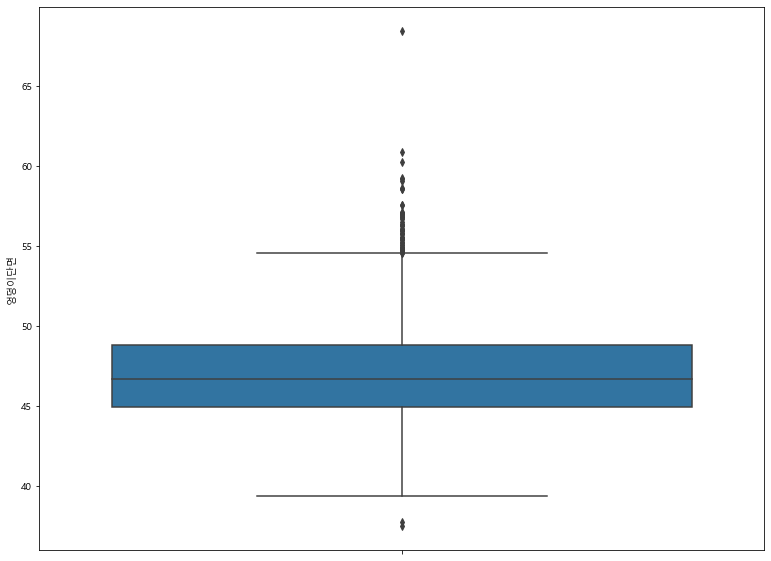

In [12]:
plt.figure(figsize=(13, 10))
sns.boxplot(data = dt_2020_df, y = '엉덩이단면')

#### 이상치 제거 함수

In [22]:
#이상치 제거 함수
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data > upper_bound) | (data < lower_bound))

In [23]:
shoulder_lead_outlier_index = outliers_iqr(dt_2020_df['어깨너비'])[0]
chest_lead_outlier_index = outliers_iqr(dt_2020_df['가슴단면'])[0]
hip_lead_outlier_index = outliers_iqr(dt_2020_df['엉덩이단면'])[0]

In [24]:
dt_2020_df.loc[shoulder_lead_outlier_index, '어깨너비']

123      49.1
179      46.7
317      46.0
528      46.5
626      33.4
757      33.8
884     999.9
1068     46.8
1092     33.7
1246     33.2
1330     33.8
1378     47.0
1551     45.9
1963     33.0
1996     49.0
2057     49.5
2081     34.0
2595     46.5
2647     47.5
2676     46.1
Name: 어깨너비, dtype: float64

In [25]:
dt_2020_df.loc[chest_lead_outlier_index, '가슴단면']

72      52.80
94      52.75
123     53.20
154     54.15
179     55.45
        ...  
2210    54.90
2223    55.00
2539    36.25
2661    54.95
2723    52.50
Name: 가슴단면, Length: 62, dtype: float64

In [26]:
dt_2020_df.loc[hip_lead_outlier_index, '엉덩이단면']

94      56.40
120     56.00
123     58.60
179     56.25
197     57.60
205     54.70
206     57.05
273     59.10
350     54.60
371     55.95
403     55.45
421     54.90
440     56.50
457     56.00
498     56.10
524     56.80
528     56.80
586     54.85
588     37.50
641     55.50
699     58.60
756     56.85
760     68.45
791     56.35
832     55.50
878     54.65
879     55.60
880     60.25
882     54.95
961     54.75
994     55.40
1008    54.85
1022    56.10
1070    55.75
1138    57.15
1189    54.85
1209    55.75
1248    56.95
1344    57.05
1669    59.25
1712    55.25
1981    54.65
2078    54.70
2095    54.90
2210    59.20
2264    55.05
2326    60.90
2365    56.70
2366    55.50
2404    55.85
2406    57.55
2408    55.05
2475    57.00
2586    54.60
2713    58.65
2723    55.20
2765    37.75
Name: 엉덩이단면, dtype: float64

In [27]:
lead_outlier_index = np.concatenate((shoulder_lead_outlier_index,
                                     chest_lead_outlier_index,
                                     hip_lead_outlier_index ), axis=None)

print(len(lead_outlier_index))
lead_outlier_index

139


array([ 123,  179,  317,  528,  626,  757,  884, 1068, 1092, 1246, 1330,
       1378, 1551, 1963, 1996, 2057, 2081, 2595, 2647, 2676,   72,   94,
        123,  154,  179,  273,  317,  444,  457,  498,  524,  528,  640,
        641,  650,  699,  741,  760,  772,  791,  832,  845,  879,  880,
        882,  954,  961,  976, 1016, 1022, 1049, 1059, 1068, 1070, 1098,
       1111, 1138, 1164, 1171, 1209, 1248, 1262, 1344, 1357, 1378, 1461,
       1475, 1478, 1571, 1669, 1692, 1699, 1712, 1780, 1835, 1887, 2058,
       2210, 2223, 2539, 2661, 2723,   94,  120,  123,  179,  197,  205,
        206,  273,  350,  371,  403,  421,  440,  457,  498,  524,  528,
        586,  588,  641,  699,  756,  760,  791,  832,  878,  879,  880,
        882,  961,  994, 1008, 1022, 1070, 1138, 1189, 1209, 1248, 1344,
       1669, 1712, 1981, 2078, 2095, 2210, 2264, 2326, 2365, 2366, 2404,
       2406, 2408, 2475, 2586, 2713, 2723, 2765], dtype=int64)

In [28]:
lead_not_outlier_index = []

for i in dt_2020_df.index:
    if i not in lead_outlier_index:
        lead_not_outlier_index.append(i)

In [29]:
dt_2020_df = dt_2020_df.loc[lead_not_outlier_index]
dt_2020_df = dt_2020_df.reset_index(drop=True)
dt_2020_df

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [30]:
dt_2020_df.to_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020.csv")

### * 군집화 함수

In [31]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

In [32]:
def visualize_silhouette(cluster_lists, X_features): 
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [33]:
dt_2020_df

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [34]:
dt_2020_km = dt_2020_df.copy()

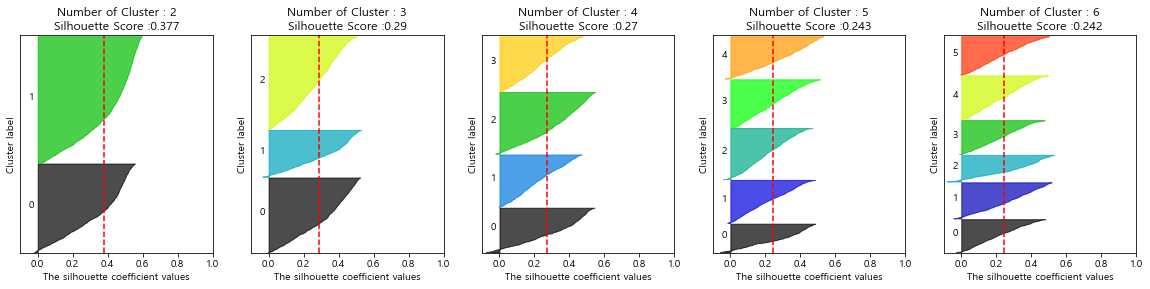

In [35]:
cluster_lists = [2,3,4,5,6]
X_features = dt_2020_km

visualize_silhouette(cluster_lists, X_features)

#plt.savefig('clustering_result.jpg')
#plt.savefig('clustering_result.png')

#### n_clusters = 4 (실루엣계수 0.27)

In [36]:
dt_2020_km4 = dt_2020_km.copy()

In [37]:
#n_clusters = 4
clusterer = KMeans(n_clusters = 4, max_iter=500, random_state=0)
cluster_labels = clusterer.fit(dt_2020_km4)
cluster_labels.labels_

array([0, 2, 2, ..., 0, 1, 3])

In [38]:
dt_2020_km4['cluster=4'] = cluster_labels.labels_
dt_2020_km4

,어깨너비,가슴단면,엉덩이단면,cluster=4
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,2
2,39.5,41.95,44.70,2
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,2
2663,40.0,39.45,43.35,2
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,1


In [39]:
#각 데이터 포인트의 실루엣 계수
sil_values = silhouette_samples(np.array(dt_2020_km), dt_2020_km4['cluster=4'])

#모든 데이터의 평균 실루엣 계수
sil_avg = silhouette_score(np.array(dt_2020_km), dt_2020_km4['cluster=4']).round(3)

print('sil_values:', sil_values)
print('sil_avg:', sil_avg)

sil_values: [0.31526226 0.2832067  0.37511465 ... 0.27418737 0.22960381 0.12741008]
sil_avg: 0.27


#### n_clusters = 5 (실루엣계수 0.243)

In [72]:
dt_2020_km5 = dt_2020_km.copy()

In [73]:
#n_clusters = 5
clusterer = KMeans(n_clusters = 5, max_iter=500, random_state=0)
cluster_labels = clusterer.fit(dt_2020_km5)
cluster_labels.labels_

array([0, 4, 4, ..., 0, 2, 2])

In [74]:
dt_2020_km5['cluster=5'] = cluster_labels.labels_
dt_2020_km5

,어깨너비,가슴단면,엉덩이단면,cluster=5
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,4
2,39.5,41.95,44.70,4
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,3
2663,40.0,39.45,43.35,4
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,2


각 데이터 포인트의 실루엣 계수<br>
sklearn.metrics.silhouette_samples(X, labels, metric='euclidean', **kwds)<br>
(X : X feature 데이터 세트, labels : 군집 레이블 값)<br>

전체 데이터의 실루엣 계수 값의 평균<br>
sklearn.metrics.silhouette_score(X, labels, metric='euclidean', sample_size=None, **kwds)

In [75]:
#각 데이터 포인트의 실루엣 계수
sil_values = silhouette_samples(np.array(dt_2020_km), dt_2020_km5['cluster=5'])

#모든 데이터의 평균 실루엣 계수
sil_avg = silhouette_score(np.array(dt_2020_km), dt_2020_km5['cluster=5']).round(3)

print('sil_values:', sil_values)
print('sil_avg:', sil_avg)

sil_values: [0.10817561 0.12527974 0.08958651 ... 0.07279671 0.12719387 0.02284275]
sil_avg: 0.243


In [93]:
dt_2020_km6.groupby('cluster=6')[['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면']].mean().round(2)

,키,어깨너비,가슴단면,허리단면,엉덩이단면
cluster=6,,,,,
0,158.18,38.69,41.03,33.95,44.28
1,165.60,42.17,48.45,43.64,51.59
2,159.79,39.85,44.74,39.18,47.34
3,156.80,40.85,49.24,46.35,50.49
4,152.20,38.60,44.39,39.83,45.69
5,166.79,40.72,42.99,36.01,46.79


In [94]:
dt_2020_km6['cluster=6'].value_counts()

2    680
0    599
5    469
4    454
3    299
1    271
Name: cluster=6, dtype: int64

0 : 3-2-1-1-1 => 8/1.6/1 (599, XS)<br>
1 : 5-6-5-5-6 => 27/5.4/6 (271, XL)<br>
2 : 4-3-4-3-4 => 18/3.6/4 (680, F)<br>
3 : 2-5-6-6-5 => 24/4.8/5 (299, L)<br>
4 : 1-1-3-4-2 => 11/2.2/2 (454, S)<br>
5 : 6-4-2-2-3 => 17/3.2/3 (469, M)

#### 0 -> XS / 1 -> XL / 2 -> Free(M~L) / 3 -> L / 4 -> S / 5 -> M (n_clusters = 6)

In [96]:
dt_2020_km6['size(6)'] = np.random.randint(2772)
size_li = []

for i in range(2772):
    if dt_2020_km6['cluster=6'][i] == 0:
        size_li.append('XS')
        
    elif dt_2020_km6['cluster=6'][i] == 1:
        size_li.append('XL')
        
    elif dt_2020_km6['cluster=6'][i] == 2:
        size_li.append('Free')
        
    elif dt_2020_km6['cluster=6'][i] == 3:
        size_li.append('L')
        
    elif dt_2020_km6['cluster=6'][i] == 4:
        size_li.append('S')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

dt_2020_km6['size(6)'] = size_li

dt_2020_km6

,키,어깨너비,가슴단면,허리단면,엉덩이단면,cluster=6,size(6)
0,168.5,38.6,49.65,44.25,49.90,1,XL
1,160.2,37.5,40.90,35.90,46.10,0,XS
2,164.2,39.5,41.95,35.55,44.70,5,M
3,158.9,36.6,43.35,36.85,46.40,2,Free
4,153.1,37.7,45.10,40.80,45.45,4,S
...,...,...,...,...,...,...,...
2767,159.7,35.8,41.60,35.95,46.10,0,XS
2768,154.8,40.0,39.45,33.95,43.35,0,XS
2769,164.5,38.0,47.10,41.45,52.95,1,XL
2770,163.5,40.5,43.40,37.70,49.40,5,M


In [97]:
dt_2020_km6['size(6)'].value_counts()

Free    680
XS      599
M       469
S       454
L       299
XL      271
Name: size(6), dtype: int64

0 : 3-2-1-1-1 => 8/1.6/1 (599, XS)<br>
1 : 5-6-5-5-6 => 27/5.4/6 (271, XL)<br>
2 : 4-3-4-3-4 => 18/3.6/4 (680, F)<br>
3 : 2-5-6-6-5 => 24/4.8/5 (299, L)<br>
4 : 1-1-3-4-2 => 11/2.2/2 (454, S)<br>
5 : 6-4-2-2-3 => 17/3.2/3 (469, M)

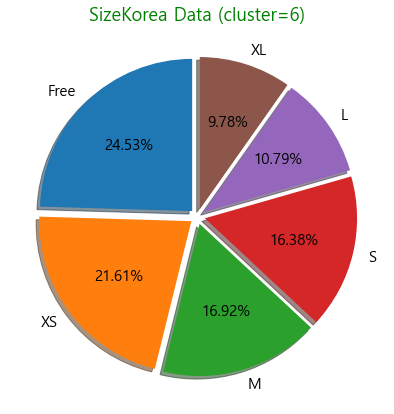

<Figure size 432x288 with 0 Axes>

In [99]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_km6['size(6)'].value_counts(), labels=('Free', 'XS', 'M', 'S', 'L', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (cluster=6)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

plt.savefig('SizeKorea_Data(cluster=6).jpg')
plt.savefig('SizeKorea_Data(cluster=6).png')

### * cluster=4

In [45]:
dt_2020_km4.groupby('cluster=4')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
cluster=4,,,
0,41.33,48.01,50.46
1,41.35,43.97,47.06
2,38.75,41.15,44.16
3,38.25,44.81,46.72


In [46]:
dt_2020_km4['cluster=4'].value_counts()

2    771
3    687
1    655
0    554
Name: cluster=4, dtype: int64

0 : 3-4-4 => 11/4 (554, XL)<br>
1 : 4-2-3 => 9/3 (655, L)<br>
2 : 2-1-1 => 4/1 (771, S)<br>
3 : 1-3-2 => 6/2 (687, M)

In [47]:
dt_2020_km4

,어깨너비,가슴단면,엉덩이단면,cluster=4
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,2
2,39.5,41.95,44.70,2
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,2
2663,40.0,39.45,43.35,2
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,1


#### 0 -> XL / 1 -> L / 2 -> S / 3 -> M (n_clusters = 4)

In [48]:
dt_2020_km4['size(n=4)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if dt_2020_km4['cluster=4'][i] == 0:
        size_li.append('XL')
        
    elif dt_2020_km4['cluster=4'][i] == 1:
        size_li.append('L')
        
    elif dt_2020_km4['cluster=4'][i] == 2:
        size_li.append('S')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

dt_2020_km4['size(n=4)'] = size_li

dt_2020_km4

,어깨너비,가슴단면,엉덩이단면,cluster=4,size(n=4)
0,38.6,49.65,49.90,0,XL
1,37.5,40.90,46.10,2,S
2,39.5,41.95,44.70,2,S
3,36.6,43.35,46.40,3,M
4,37.7,45.10,45.45,3,M
...,...,...,...,...,...
2662,35.8,41.60,46.10,2,S
2663,40.0,39.45,43.35,2,S
2664,38.0,47.10,52.95,0,XL
2665,40.5,43.40,49.40,1,L


In [49]:
dt_2020_km4['size(n=4)'].value_counts()

S     771
M     687
L     655
XL    554
Name: size(n=4), dtype: int64

In [50]:
dt_2020_km4.groupby('size(n=4)')[['size(n=4)']].count()

,size(n=4)
size(n=4),
L,655
M,687
S,771
XL,554


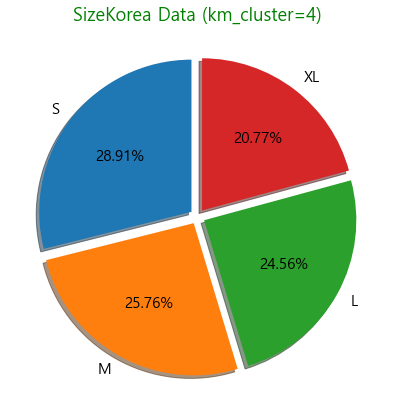

In [52]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_km4['size(n=4)'].value_counts(), labels=('S', 'M', 'L', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (km_cluster=4)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(cluster=4).png')
#plt.savefig('SizeKorea_Data(cluster=4).jpg')

In [53]:
dt_2020_km4.to_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_km4.csv")

### * cluster=5

In [76]:
dt_2020_km5

,어깨너비,가슴단면,엉덩이단면,cluster=5
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,4
2,39.5,41.95,44.70,4
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,3
2663,40.0,39.45,43.35,4
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,2


In [77]:
dt_2020_km5.groupby('cluster=5')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
cluster=5,,,
0,41.80,48.70,51.08
1,41.21,42.87,46.14
2,40.22,45.88,48.47
3,38.07,44.09,45.94
4,38.45,40.67,43.76


In [78]:
dt_2020_km5['cluster=5'].value_counts()

2    641
3    601
1    539
4    530
0    356
Name: cluster=5, dtype: int64

0 : 5-5-5 => 15/5 (356, XL)<br>
1 : 4-2-3 => 9/3 (539, F)<br>
2 : 3-4-4 => 11/4 (641, L)<br>
3 : 1-3-2 => 6/2 (601, M)<br>
4 : 2-1-1 => 4/1 (530, S)

In [79]:
dt_2020_km5

,어깨너비,가슴단면,엉덩이단면,cluster=5
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,4
2,39.5,41.95,44.70,4
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,3
2663,40.0,39.45,43.35,4
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,2


#### 0 -> XL / 1 -> Free / 2 -> L / 3 -> M / 4 -> S (n_clusters = 5)

In [80]:
dt_2020_km5['size(n=5)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if dt_2020_km5['cluster=5'][i] == 0:
        size_li.append('XL')
        
    elif dt_2020_km5['cluster=5'][i] == 1:
        size_li.append('Free')
        
    elif dt_2020_km5['cluster=5'][i] == 2:
        size_li.append('L')
        
    elif dt_2020_km5['cluster=5'][i] == 3:
        size_li.append('M')
        
    else:
        size_li.append('S')
        
#print(size_lst)
#print()

dt_2020_km5['size(n=5)'] = size_li

dt_2020_km5

,어깨너비,가슴단면,엉덩이단면,cluster=5,size(n=5)
0,38.6,49.65,49.90,0,XL
1,37.5,40.90,46.10,4,S
2,39.5,41.95,44.70,4,S
3,36.6,43.35,46.40,3,M
4,37.7,45.10,45.45,3,M
...,...,...,...,...,...
2662,35.8,41.60,46.10,3,M
2663,40.0,39.45,43.35,4,S
2664,38.0,47.10,52.95,0,XL
2665,40.5,43.40,49.40,2,L


In [81]:
dt_2020_km5['size(n=5)'].value_counts()

L       641
M       601
Free    539
S       530
XL      356
Name: size(n=5), dtype: int64

In [82]:
dt_2020_km5.groupby('size(n=5)')[['size(n=5)']].count()

,size(n=5)
size(n=5),
Free,539
L,641
M,601
S,530
XL,356


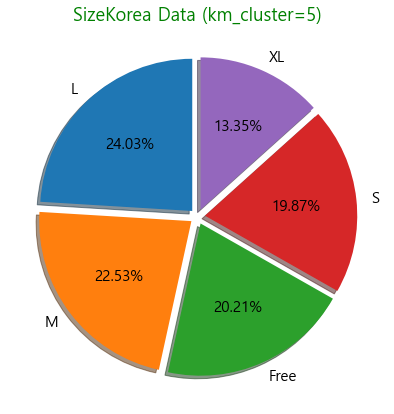

In [83]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_km5['size(n=5)'].value_counts(), labels=('L', 'M', 'Free', 'S', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (km_cluster=5)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(cluster=4).png')
#plt.savefig('SizeKorea_Data(cluster=4).jpg')

In [84]:
dt_2020_km5.to_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_km5.csv")

## 4) 사이즈코리아 데이터 군집화 (평균이동)
features : 키, 어깨너비, 가슴둘레, 허리둘레, 엉덩이둘레<br>
'2020_size_measures.csv' 파일은 20세 이상 성인에 대한 데이터이다<br>
002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레 ,

In [85]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [86]:
dt_2020_ms = dt_2020_df.copy()
dt_2020_ms

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


### * 최적의 대역폭 계산

In [87]:
bandwidth = estimate_bandwidth(dt_2020_ms)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 4.119


In [88]:
best_bandwidth = estimate_bandwidth(dt_2020_ms)

meanshift = MeanShift(bandwidth=best_bandwidth)

cluster_labels = meanshift.fit_predict(dt_2020_ms)

dt_2020_ms['meanshift_label'] = cluster_labels

print(dt_2020_ms['meanshift_label'].value_counts())

centers = meanshift.cluster_centers_

unique_labels = np.unique(cluster_labels)

0    2667
Name: meanshift_label, dtype: int64


In [89]:
dt_2020_ms.groupby('meanshift_label')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
meanshift_label,,,
0,39.79,44.21,46.84


In [90]:
dt_2020_ms.groupby('meanshift_label')[['meanshift_label']].count()

,meanshift_label
meanshift_label,
0,2667


## 5) 사이즈코리아 데이터 군집화 (GMM)
features : 키, 어깨너비, 가슴둘레, 허리둘레, 엉덩이둘레<br>
'2020_size_measures.csv' 파일은 20세 이상 성인에 대한 데이터이다<br>
002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레 ,

In [91]:
from sklearn.mixture import GaussianMixture

In [92]:
#dt_2020_df = pd.read_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020.csv").iloc[:, 1:]
dt_2020_df

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


### * n_components=6

In [93]:
dt_2020_gm6 = dt_2020_df.copy()
dt_2020_gm6

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [94]:
# gmm으로 군집화
gmm = GaussianMixture(n_components=6, random_state=0).fit(dt_2020_gm6)
gmm_cluster_labels = gmm.predict(dt_2020_gm6)

# 클러스터링 결과 저장
dt_2020_gm6['gmm_cluster=6'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인
dt_2020_gm6['gmm_cluster=6'].value_counts()

4    575
1    460
5    440
0    422
3    421
2    349
Name: gmm_cluster=6, dtype: int64

In [95]:
dt_2020_gm6.groupby('gmm_cluster=6')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
gmm_cluster=6,,,
0,38.90,45.95,48.75
1,38.36,40.52,43.57
2,41.78,48.84,50.95
3,41.69,45.33,47.53
4,38.43,44.01,45.45
5,40.54,41.94,46.32


0 : 3-5-5 => 13/5 (422, L)<br>
1 : 1-1-1 => 3/1 (460, XS)<br>
2 : 6-6-6 => 18/6 (349, XL)<br>
3 : 5-4-4 => 13/4 (421, F)<br>
4 : 2-3-2 => 7/2 (575, S)<br>
5 : 4-2-3 => 9/3 (440, M)

#### 0 -> L / 1 -> XS / 2 -> XL / 3 -> Free(M~L) / 4 -> S / 5 -> M

In [96]:
dt_2020_gm6['size(n=6)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if dt_2020_gm6['gmm_cluster=6'][i] == 0:
        size_li.append('L')
        
    elif dt_2020_gm6['gmm_cluster=6'][i] == 1:
        size_li.append('XS')
        
    elif dt_2020_gm6['gmm_cluster=6'][i] == 2:
        size_li.append('XL')
        
    elif dt_2020_gm6['gmm_cluster=6'][i] == 3:
        size_li.append('Free')
        
    elif dt_2020_gm6['gmm_cluster=6'][i] == 4:
        size_li.append('S')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

dt_2020_gm6['size(n=6)'] = size_li

dt_2020_gm6

,어깨너비,가슴단면,엉덩이단면,gmm_cluster=6,size(n=6)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,XS
2,39.5,41.95,44.70,1,XS
3,36.6,43.35,46.40,4,S
4,37.7,45.10,45.45,4,S
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,XS
2663,40.0,39.45,43.35,1,XS
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,0,L


In [97]:
dt_2020_gm6['size(n=6)'].value_counts()

S       575
XS      460
M       440
L       422
Free    421
XL      349
Name: size(n=6), dtype: int64

In [98]:
dt_2020_gm6.to_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm6.csv")

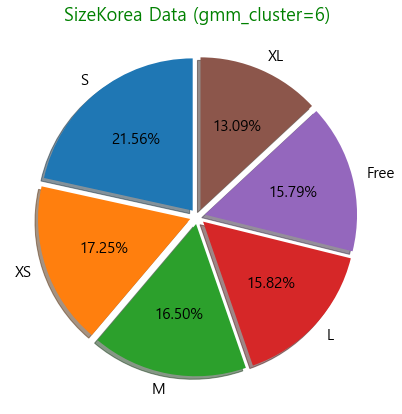

In [99]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_gm6['size(n=6)'].value_counts(), labels=('S', 'XS', 'M', 'L', 'Free', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (gmm_cluster=6)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(gmm_cluster=6).png')
#plt.savefig('SizeKorea_Data(gmm_cluster=6).jpg')

### * n_components=5

In [101]:
dt_2020_gm5 = dt_2020_df.copy()
dt_2020_gm5

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [102]:
# gmm으로 군집화
gmm = GaussianMixture(n_components=5, random_state=0).fit(dt_2020_gm5)
gmm_cluster_labels = gmm.predict(dt_2020_gm5)

# 클러스터링 결과 저장
dt_2020_gm5['gmm_cluster=5'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인
dt_2020_gm5['gmm_cluster=5'].value_counts()

0    599
3    593
4    589
1    492
2    394
Name: gmm_cluster=5, dtype: int64

In [103]:
dt_2020_gm5.groupby('gmm_cluster=5')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
gmm_cluster=5,,,
0,38.16,45.01,46.47
1,38.14,40.65,43.74
2,41.60,48.71,50.78
3,41.10,45.25,48.21
4,40.32,42.32,45.79


0 : 2-3-3 => 3 (599, F)<br>
1 : 1-1-1 => 1 (492, S)<br>
2 : 5-5-5 => 5 (394, XL)<br>
3 : 4-4-4 => 4 (593, L)<br>
4 : 3-2-2 => 2 (589, M)

#### 0 -> Free(M~L) / 1 -> S / 2 -> XL / 3 -> L / 4 -> M

In [104]:
dt_2020_gm5['size(n=5)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if dt_2020_gm5['gmm_cluster=5'][i] == 0:
        size_li.append('Free')
        
    elif dt_2020_gm5['gmm_cluster=5'][i] == 1:
        size_li.append('S')
        
    elif dt_2020_gm5['gmm_cluster=5'][i] == 2:
        size_li.append('XL')
        
    elif dt_2020_gm5['gmm_cluster=5'][i] == 3:
        size_li.append('L')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

dt_2020_gm5['size(n=5)'] = size_li

dt_2020_gm5

,어깨너비,가슴단면,엉덩이단면,gmm_cluster=5,size(n=5)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,S
2,39.5,41.95,44.70,4,M
3,36.6,43.35,46.40,0,Free
4,37.7,45.10,45.45,0,Free
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,S
2663,40.0,39.45,43.35,1,S
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,3,L


In [105]:
dt_2020_gm5['size(n=5)'].value_counts()

Free    599
L       593
M       589
S       492
XL      394
Name: size(n=5), dtype: int64

In [183]:
dt_2020_gm5.groupby('size(n=5)')[['size(n=5)']].count()

,size(n=5)
size(n=5),
Free,599
L,593
M,589
S,492
XL,394


In [106]:
dt_2020_gm5.to_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm5.csv")

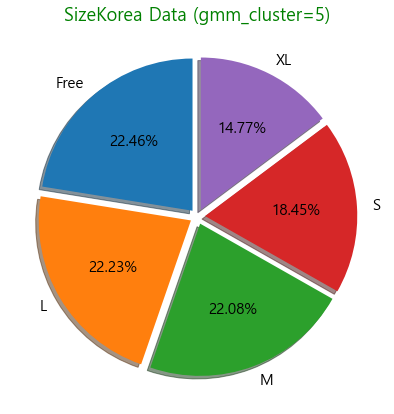

In [107]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_gm5['size(n=5)'].value_counts(), labels=('Free', 'L', 'M', 'S', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (gmm_cluster=5)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(gmm_cluster=6).png')
#plt.savefig('SizeKorea_Data(gmm_cluster=6).jpg')

### * n_components=4

In [108]:
dt_2020_gm4 = dt_2020_df.copy()
dt_2020_gm4

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [109]:
# gmm으로 군집화
gmm = GaussianMixture(n_components=4, random_state=0).fit(dt_2020_gm4)
gmm_cluster_labels = gmm.predict(dt_2020_gm4)

# 클러스터링 결과 저장
dt_2020_gm4['gmm_cluster=4'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인
dt_2020_gm4['gmm_cluster=4'].value_counts()

1    852
0    688
3    573
2    554
Name: gmm_cluster=4, dtype: int64

In [110]:
dt_2020_gm4.groupby('gmm_cluster=4')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
gmm_cluster=4,,,
0,38.40,44.94,46.63
1,38.75,41.23,44.45
2,41.45,47.94,50.48
3,41.43,44.17,47.13


0 : 1-3-2 => 6/2 (688, M)<br>
1 : 2-1-1 => 4/1 (852, S)<br>
2 : 4-4-4 => 12/4 (554, XL)<br>
3 : 3-2-3 => 8/3 (573, L)

#### 0 -> M / 1 -> S / 2 -> XL / 3 -> L

In [111]:
dt_2020_gm4['size(n=4)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if dt_2020_gm4['gmm_cluster=4'][i] == 0:
        size_li.append('M')
        
    elif dt_2020_gm4['gmm_cluster=4'][i] == 1:
        size_li.append('S')
        
    elif dt_2020_gm4['gmm_cluster=4'][i] == 2:
        size_li.append('XL')
        
    else:
        size_li.append('L')
        
#print(size_lst)
#print()

dt_2020_gm4['size(n=4)'] = size_li

dt_2020_gm4

,어깨너비,가슴단면,엉덩이단면,gmm_cluster=4,size(n=4)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,S
2,39.5,41.95,44.70,1,S
3,36.6,43.35,46.40,0,M
4,37.7,45.10,45.45,0,M
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,S
2663,40.0,39.45,43.35,1,S
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,3,L


In [112]:
dt_2020_gm4['size(n=4)'].value_counts()

S     852
M     688
L     573
XL    554
Name: size(n=4), dtype: int64

In [184]:
dt_2020_gm4.groupby('size(n=4)')[['size(n=4)']].count()

,size(n=4)
size(n=4),
L,573
M,688
S,852
XL,554


In [113]:
dt_2020_gm4.to_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm4.csv")

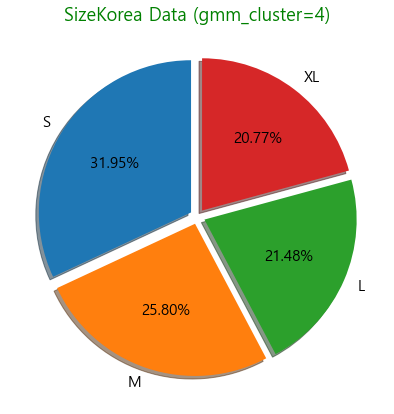

In [114]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_2020_gm4['size(n=4)'].value_counts(), labels=('S', 'M', 'L', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (gmm_cluster=4)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(gmm_cluster=6).png')
#plt.savefig('SizeKorea_Data(gmm_cluster=6).jpg')

## 6) 사이즈코리아 데이터 군집화 (DBSCAN)
features : 키, 어깨너비, 가슴둘레, 허리둘레, 엉덩이둘레<br>
'2020_size_measures.csv' 파일은 20세 이상 성인에 대한 데이터이다<br>
002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레 ,

In [115]:
from sklearn.cluster import DBSCAN

In [116]:
dt_2020_db = dt_2020_df.copy()
dt_2020_db

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [117]:
# 주변 영역 반경 = 0.6, 최소 데이터 개수 = 8
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(dt_2020_db)

# 군집화된 레이블 값 저장
dt_2020_db['dbscan_cluster'] = dbscan_labels

# 예측 비교
dt_2020_db['dbscan_cluster'].value_counts()

-1     1258
 0     1212
 4       20
 8       17
 5       14
 16      12
 17      11
 14      11
 2       10
 12      10
 1        9
 6        9
 9        9
 7        9
 3        8
 13       8
 18       8
 19       8
 20       8
 15       6
 10       6
 11       4
Name: dbscan_cluster, dtype: int64

In [118]:
# 주변 영역 반경 = 0.8, 최소 데이터 개수 = 8
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(dt_2020_db)

# 군집화된 레이블 값 저장
dt_2020_db['dbscan_cluster'] = dbscan_labels

# 예측 비교
dt_2020_db['dbscan_cluster'].value_counts()

 1     1212
-1      846
 2       64
 14      59
 15      32
 6       27
 22      24
 30      23
 29      22
 8       20
 31      18
 28      17
 9       16
 0       14
 11      14
 40      13
 20      12
 37      11
 18      11
 10      11
 12      11
 27      10
 17      10
 5       10
 33      10
 21       9
 19       9
 25       9
 36       9
 3        9
 16       9
 4        9
 24       9
 39       8
 38       8
 34       8
 41       8
 26       8
 7        8
 23       8
 42       8
 35       6
 32       6
 13       2
Name: dbscan_cluster, dtype: int64

In [119]:
# 주변 영역 반경 = 0.3, 최소 데이터 개수 = 3
dbscan = DBSCAN(eps=0.3, min_samples=3, metric='euclidean')
dbscan_labels = dbscan.fit_predict(dt_2020_db)

# 군집화된 레이블 값 저장
dt_2020_db['dbscan_cluster'] = dbscan_labels

# 예측 비교
dt_2020_db['dbscan_cluster'].value_counts()

-1      2089
 11       17
 52       13
 5        13
 33       13
        ... 
 81        3
 43        3
 107       3
 101       3
 119       3
Name: dbscan_cluster, Length: 133, dtype: int64

In [120]:
dt_2020_db.groupby('dbscan_cluster')[['dbscan_cluster']].count()

,dbscan_cluster
dbscan_cluster,
-1,2089
0,3
1,5
2,7
3,4
...,...
127,3
128,3
129,3


## 7) 웹크롤링 (브랜드명, 상품명 추가) 1~100page

### * 원피스 전체 상품 크롤링 (+브랜드명, 상품명)
모든 측정 데이터(총장, 어깨너비, 가슴단면, 소매길이, 허리단면, 엉덩이단면)를 갖고 있는 상품만 가져온다

In [ ]:
#1~100페이지 내의 상품 접속 '링크만' 추출
#soup.select(selector= '#searchList > li:nth-child(1) > div.li_inner > div.article_info > p.list_info > a')

dresses = []

for i in range(1, 101):
    url = f'https://www.musinsa.com/categories/item/020?d_cat_cd=020&brand=&list_kind=small&sort=sale_high&sub_sort=3m&page={i}&display_cnt=90&group_sale=&exclusive_yn=&sale_goods=&timesale_yn=&ex_soldout=&kids=&color=&price1=&price2=&shoeSizeOption=&tags=&campaign_id=&includeKeywords=&measure='
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html.parser')
    #사이트 내 상품명 & 링크
    products = soup.select(selector = 'p.list_info > a')
    
    #링크만 추출
    for product in products:
        dresses.append(product['href'])

dress_links = []

#링크 모음 리스트 dresses 내에 있는 링크에 대한 조건문
for dress in dresses:
    if 'http:' in dress:
        pass
    elif 'https:' in dress:
        pass
    else:
        dress = 'http:' + dress
        dress_links.append(dress)
        
dress_links

In [95]:
header = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}
dress_brands = pd.DataFrame()

for link in dress_links:
        html = requests.get(link, headers = header).text
        soup = BeautifulSoup(html, 'html.parser')
        measures = soup.find_all(class_ = 'item_val')    #사이즈표의 칼럼명
        size_cats = soup.select('#size_table > tbody > tr > th')    #사이즈표의 사이즈명
        brand_names = soup.select('strong > a') # #product_order_info > div.explan_product.product_info_section > ul > li:nth-child(1) > p.product_article_contents > strong > a
        product_names = soup.select('div.right_contents.section_product_summary > span > em') # #page_product_detail > div.right_area.page_detail_product > div.right_contents.section_product_summary > span > em
        
        if measures:
            
            measure_parts = [measure.text.strip() for measure in measures]    #총장, 어깨너비, ...
            
            if len(measure_parts) == 5:
                size_cate = [cate.text.strip() for cate in size_cats][1:]         #S, M, ...
                brand_nm = [x.text.strip() for x in brand_names]                  #브랜드명
                product_nm = [x.text.strip() for x in product_names]              #상품명
            
            
                size_val = []    #실제적인 사이즈 치수 모음 리스트 (40.6, ...)

                for j in range(3, len(size_cats) + 3):
                    for i in range(2, len(measure_parts) + 2):
                        types = soup.select(f'#size_table > tbody > tr:nth-child({j}) > td:nth-child({i})')
                        types = re.sub('[^0-9.]', ' ', str(types))
                        size_val.append(types.strip())

                size_val = [v for v in size_val if v]


                n = len(measure_parts)    #사이즈표 칼럼명의 개수
                results = [size_val[i * n:(i + 1) * n] for i in range((len(size_val) + n - 1) // n)]        
                mps = measure_parts * (len(results))

                measure_parts = measure_parts * (int(len(size_val) / len(measure_parts)))


                categories = []

                n = int(len(size_val) / len(size_cate))

                for size in size_cate:
                     for i in range(n):
                        categories.append(size)

                brand_nm = brand_nm * len(size_val)
                product_nm = product_nm * len(size_val)

                size_val_df = pd.DataFrame(size_val)
                size_cate_df = pd.DataFrame(categories)
                measure_part_df = pd.DataFrame(measure_parts)
                brand_nm_df = pd.DataFrame(brand_nm)
                product_nm_df = pd.DataFrame(product_nm)

                df_1 = pd.concat([size_val_df, size_cate_df, measure_part_df, brand_nm_df, product_nm_df], axis = 1)

                dress_brands = pd.concat([dress_brands, df_1], axis = 0)

            else:
                continue
            
        else:
            continue
    
dress_brands

,0,0,0,0,0
0,109,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
10,114,m,총장,LIENLIER,로즈퍼프원피스 - 카키
11,35,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
12,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
13,60,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [96]:
dress_brands.columns = ['values', 'size', 'measures', 'brand_name', 'product_name']
dress_brands

,values,size,measures,brand_name,product_name
0,109,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
10,114,m,총장,LIENLIER,로즈퍼프원피스 - 카키
11,35,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
12,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
13,60,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


### * 결측치 제거

In [127]:
dress_brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9035 entries, 0 to 9034
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   values        9035 non-null   float64
 1   size          9035 non-null   object 
 2   measures      9035 non-null   object 
 3   brand_name    9035 non-null   object 
 4   product_name  9035 non-null   object 
dtypes: float64(1), object(4)
memory usage: 353.1+ KB


In [128]:
dress_brands.isnull().sum()

values          0
size            0
measures        0
brand_name      0
product_name    0
dtype: int64

In [ ]:
dress_brands.dropna(axis=0, inplace=True)

In [ ]:
dress_brands.info()

In [ ]:
dress_brands.reset_index(inplace=True)
dress_brands

In [ ]:
dress_brands = dress_brands.iloc[:, 1:]
dress_brands

In [ ]:
dress_brands

In [145]:
dress_brands['measures'].value_counts()

총장       1807
엉덩이단면    1807
어깨너비     1806
가슴단면     1806
소매길이     1806
허리단면        1
밑위          1
밑단단면        1
Name: measures, dtype: int64

In [146]:
dress_brands.iloc[8015, :]

values                           105.0
size                              FREE
measures                            총장
brand_name                        SY2C
product_name    실키 스모크 셋업(팬츠) [3color]
Name: 8015, dtype: object

In [147]:
dress_brands[dress_brands['measures'] == '허리단면']

,values,size,measures,brand_name,product_name
8016,33.0,FREE,허리단면,SY2C,실키 스모크 셋업(팬츠) [3color]


In [148]:
dress_brands.iloc[8017, :]

values                            46.0
size                              FREE
measures                         엉덩이단면
brand_name                        SY2C
product_name    실키 스모크 셋업(팬츠) [3color]
Name: 8017, dtype: object

In [149]:
dress_brands[dress_brands['measures'] == '밑위']

,values,size,measures,brand_name,product_name
8018,31.0,FREE,밑위,SY2C,실키 스모크 셋업(팬츠) [3color]


In [150]:
dress_brands[dress_brands['measures'] == '밑단단면']

,values,size,measures,brand_name,product_name
8019,28.0,FREE,밑단단면,SY2C,실키 스모크 셋업(팬츠) [3color]


In [151]:
dress_brands.drop(index=[8015, 8016, 8017, 8018, 8019], axis=1, inplace=True)
dress_brands

,values,size,measures,brand_name,product_name
0,109.0,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57.0,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
9030,114.0,m,총장,LIENLIER,로즈퍼프원피스 - 카키
9031,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
9032,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
9033,60.0,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [152]:
dress_brands['measures'].value_counts()

총장       1806
어깨너비     1806
가슴단면     1806
소매길이     1806
엉덩이단면    1806
Name: measures, dtype: int64

In [153]:
dress_brands = dress_brands.reset_index().iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,109.0,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57.0,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
9025,114.0,m,총장,LIENLIER,로즈퍼프원피스 - 카키
9026,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
9027,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
9028,60.0,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
dress_brands.to_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_100.csv")

In [124]:
dress_brands = pd.read_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_100.csv").iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,109.0,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57.0,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
9025,114.0,m,총장,LIENLIER,로즈퍼프원피스 - 카키
9026,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
9027,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
9028,60.0,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [125]:
dress_brands['measures'].value_counts()

총장       1806
어깨너비     1806
가슴단면     1806
소매길이     1806
엉덩이단면    1806
Name: measures, dtype: int64

In [140]:
drop_total_long_index = [x for x in dress_brands[dress_brands['measures'] == '총장'].index]
drop_total_long_index

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170,
 175,
 180,
 185,
 190,
 195,
 200,
 205,
 210,
 215,
 220,
 225,
 230,
 235,
 240,
 245,
 250,
 255,
 260,
 265,
 270,
 275,
 280,
 285,
 290,
 295,
 300,
 305,
 310,
 315,
 320,
 325,
 330,
 335,
 340,
 345,
 350,
 355,
 360,
 365,
 370,
 375,
 380,
 385,
 390,
 395,
 400,
 405,
 410,
 415,
 420,
 425,
 430,
 435,
 440,
 445,
 450,
 455,
 460,
 465,
 470,
 475,
 480,
 485,
 490,
 495,
 500,
 505,
 510,
 515,
 520,
 525,
 530,
 535,
 540,
 545,
 550,
 555,
 560,
 565,
 570,
 575,
 580,
 585,
 590,
 595,
 600,
 605,
 610,
 615,
 620,
 625,
 630,
 635,
 640,
 645,
 650,
 655,
 660,
 665,
 670,
 675,
 680,
 685,
 690,
 695,
 700,
 705,
 710,
 715,
 720,
 725,
 730,
 735,
 740,
 745,
 750,
 755,
 760,
 765,
 770,
 775,
 780,
 785,
 790,
 795,
 800,
 805,
 810,
 815,
 820,
 825,
 830,
 835,
 840,
 845,
 8

In [145]:
len(drop_total_long_index)

1806

In [148]:
dress_brands = dress_brands.drop(index = drop_total_long_index).reset_index(drop=True)

In [150]:
drop_arms_long_index = [x for x in dress_brands[dress_brands['measures'] == '소매길이'].index]
drop_arms_long_index

[2,
 6,
 10,
 14,
 18,
 22,
 26,
 30,
 34,
 38,
 42,
 46,
 50,
 54,
 58,
 62,
 66,
 70,
 74,
 78,
 82,
 86,
 90,
 94,
 98,
 102,
 106,
 110,
 114,
 118,
 122,
 126,
 130,
 134,
 138,
 142,
 146,
 150,
 154,
 158,
 162,
 166,
 170,
 174,
 178,
 182,
 186,
 190,
 194,
 198,
 202,
 206,
 210,
 214,
 218,
 222,
 226,
 230,
 234,
 238,
 242,
 246,
 250,
 254,
 258,
 262,
 266,
 270,
 274,
 278,
 282,
 286,
 290,
 294,
 298,
 302,
 306,
 310,
 314,
 318,
 322,
 326,
 330,
 334,
 338,
 342,
 346,
 350,
 354,
 358,
 362,
 366,
 370,
 374,
 378,
 382,
 386,
 390,
 394,
 398,
 402,
 406,
 410,
 414,
 418,
 422,
 426,
 430,
 434,
 438,
 442,
 446,
 450,
 454,
 458,
 462,
 466,
 470,
 474,
 478,
 482,
 486,
 490,
 494,
 498,
 502,
 506,
 510,
 514,
 518,
 522,
 526,
 530,
 534,
 538,
 542,
 546,
 550,
 554,
 558,
 562,
 566,
 570,
 574,
 578,
 582,
 586,
 590,
 594,
 598,
 602,
 606,
 610,
 614,
 618,
 622,
 626,
 630,
 634,
 638,
 642,
 646,
 650,
 654,
 658,
 662,
 666,
 670,
 674,
 678,
 682,
 

In [151]:
len(drop_arms_long_index)

1806

In [152]:
dress_brands = dress_brands.drop(index = drop_arms_long_index).reset_index(drop=True)
dress_brands

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [153]:
dress_brands.to_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_100_columns3.csv")

In [154]:
dress_brands = pd.read_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_100_columns3.csv").iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


### ① 의미없는 사이즈 표기 제외

In [155]:
dress_brands['size'].unique()

array(['xs', 's', 'm', 'S', 'M', 'FREE', '프리사이즈', 'OS', '55', '66', '77',
       '88', '옵션없음', 'charcoal', 'S_085', 'M_088', 'L_091', 'Free', 'XS',
       'L', '1(S)', '2(M)', '1(55)', '2(66)', '090', '095', 'ONE SIZE',
       'SMALL_55', 'MEDIUM_66', '085', 'XL', '34(S)', '36(M)', '32(XS)',
       '2', '3', 'One', 'F', 'black', 'SHORT', 'LONG', 'Short ver.',
       'Long ver.', 'free', '34', '36', '38', '1', '00(S)', '0(M)', '85',
       '90', '0-7599412220', '2-7599412222', '4-7599412224',
       '6-7599412226', '8-7599412228', '0-7599412120', '2-7599412122',
       '4-7599412124', '6-7599412126', '8-7599412128', 'XS-6679222001',
       'S-6679222002', 'M-6679222003', 'F/아이보리', 'ONE', '01(XS(85))',
       '02(S(90))', '03(M(95))', '04(L(100))', 'Small', 'Medium', 'Large',
       '55S', '66M', '44~55', 'One size (44~마른66)', 'XS-M', 'M-XL',
       '0-6679375220', '2-6679375222', '4-6679375224', '6-6679375226',
       '핑크', '브라운', '퍼플', '옐로우', '초록', '블랙', '네이비', '38(55) S',
       '40(6

In [157]:
drop_size_columns = ['55', '66', '77',
       '88', 'charcoal', '1(55)', '2(66)', '090', '095', '085', 
       '2', '3', 'black', 'SHORT', 'LONG', 'Short ver.',
       'Long ver.', '34', '36', '38', '1', '85',
       '90', '0-7599412220', '2-7599412222', '4-7599412224',
       '6-7599412226', '8-7599412228', '0-7599412120', '2-7599412122',
       '4-7599412124', '6-7599412126', '8-7599412128', '44~55', 'One size (44~마른66)', 'XS-M', 'M-XL',
       '0-6679375220', '2-6679375222', '4-6679375224', '6-6679375226',
       '핑크', '브라운', '퍼플', '옐로우', '초록', '블랙', '네이비', '40', '2-7599384022',
       '4-7599384024', '0-7599393720', '2-7599393722', '4-7599393724',
       'S-7599432002', 'M-7599432003', 'L-7599432004', '0-7599398320',
       '2-7599398322', '4-7599398324', '0-7599436420', '2-7599436422',
       '4-7599436424', '6-7599436426', '0-6679239620', '2-6679239622',
       '4-6679239624', '6-6679239626', 'Black', '_0', 'SM', '080', 'ivory', 'XXL', '055', '066',
       '블랙/55', '블랙/66', '크림/55', '크림/66']

drop_index = []

for i in range(len(dress_brands['size'])):
    if dress_brands['size'][i] in drop_size_columns:
        drop_index.append(i)
        #print(dress_data.drop(dress_data.iloc[i, :], axis=0))
    else:
        continue

dress_brands.drop(drop_index, inplace=True)

#print('drop_index:', drop_index)
#print()
print('unique:', dress_brands['size'].unique())

unique: ['xs' 's' 'm' 'S' 'M' 'FREE' '프리사이즈' 'OS' '옵션없음' 'S_085' 'M_088' 'L_091'
 'Free' 'XS' 'L' '1(S)' '2(M)' 'ONE SIZE' 'SMALL_55' 'MEDIUM_66' 'XL'
 '34(S)' '36(M)' '32(XS)' 'One' 'F' 'free' '00(S)' '0(M)' 'XS-6679222001'
 'S-6679222002' 'M-6679222003' 'F/아이보리' 'ONE' '01(XS(85))' '02(S(90))'
 '03(M(95))' '04(L(100))' 'Small' 'Medium' 'Large' '55S' '66M' '38(55) S'
 '40(66) M' '42(77) L' 'MIDDLE' 'XS（44）' 'S（55）' 'M（66）' 'L（77）'
 'One Size' 'SMALL' 'MEDIUM' '화이트/00（S／44~55）' '화이트/0（M／55~66）'
 '베이지/00（S／44~55）' '베이지/0（M／55~66）' '블랙／네이비/00（S／44~55）'
 '블랙／네이비/0（M／55~66）' '블랙/00（S／44~55）' '블랙/0（M／55~66）'
 '블랙／스트라이프/00（S／44~55）' '블랙／스트라이프/0（M／55~66）' 'sora-free' '수피마원피스S'
 '수피마원피스M' '수피마 원피스 S' '수피마 원피스 M' '수피마 원피스  S' 'FREE SIZE']


In [ ]:
#mini_dress_data.isin(drop_size_columns).sum()
#mini_dress_data[mini_dress_data['size'] in drop_size_columns]

In [158]:
dress_brands = dress_brands.reset_index().iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4552,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4553,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4554,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4555,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


### ② 사이즈 표기 통일 (FREE, XS, S, M, L, XL)

In [159]:
dress_brands['size'].unique()

array(['xs', 's', 'm', 'S', 'M', 'FREE', '프리사이즈', 'OS', '옵션없음', 'S_085',
       'M_088', 'L_091', 'Free', 'XS', 'L', '1(S)', '2(M)', 'ONE SIZE',
       'SMALL_55', 'MEDIUM_66', 'XL', '34(S)', '36(M)', '32(XS)', 'One',
       'F', 'free', '00(S)', '0(M)', 'XS-6679222001', 'S-6679222002',
       'M-6679222003', 'F/아이보리', 'ONE', '01(XS(85))', '02(S(90))',
       '03(M(95))', '04(L(100))', 'Small', 'Medium', 'Large', '55S',
       '66M', '38(55) S', '40(66) M', '42(77) L', 'MIDDLE', 'XS（44）',
       'S（55）', 'M（66）', 'L（77）', 'One Size', 'SMALL', 'MEDIUM',
       '화이트/00（S／44~55）', '화이트/0（M／55~66）', '베이지/00（S／44~55）',
       '베이지/0（M／55~66）', '블랙／네이비/00（S／44~55）', '블랙／네이비/0（M／55~66）',
       '블랙/00（S／44~55）', '블랙/0（M／55~66）', '블랙／스트라이프/00（S／44~55）',
       '블랙／스트라이프/0（M／55~66）', 'sora-free', '수피마원피스S', '수피마원피스M',
       '수피마 원피스 S', '수피마 원피스 M', '수피마 원피스  S', 'FREE SIZE'], dtype=object)

#### * size 표기를 모두 대문자로 변경

In [160]:
for i in range(len(dress_brands['size'])):
    dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].upper()

print(dress_brands['size'].unique())

['XS' 'S' 'M' 'FREE' '프리사이즈' 'OS' '옵션없음' 'S_085' 'M_088' 'L_091' 'L'
 '1(S)' '2(M)' 'ONE SIZE' 'SMALL_55' 'MEDIUM_66' 'XL' '34(S)' '36(M)'
 '32(XS)' 'ONE' 'F' '00(S)' '0(M)' 'XS-6679222001' 'S-6679222002'
 'M-6679222003' 'F/아이보리' '01(XS(85))' '02(S(90))' '03(M(95))' '04(L(100))'
 'SMALL' 'MEDIUM' 'LARGE' '55S' '66M' '38(55) S' '40(66) M' '42(77) L'
 'MIDDLE' 'XS（44）' 'S（55）' 'M（66）' 'L（77）' '화이트/00（S／44~55）'
 '화이트/0（M／55~66）' '베이지/00（S／44~55）' '베이지/0（M／55~66）' '블랙／네이비/00（S／44~55）'
 '블랙／네이비/0（M／55~66）' '블랙/00（S／44~55）' '블랙/0（M／55~66）'
 '블랙／스트라이프/00（S／44~55）' '블랙／스트라이프/0（M／55~66）' 'SORA-FREE' '수피마원피스S'
 '수피마원피스M' '수피마 원피스 S' '수피마 원피스 M' '수피마 원피스  S' 'FREE SIZE']


#### * 사이즈 표기 통일 (Free, XS, S, M, L, XL)

In [161]:
#re.sub(".+123.+", "#", string)
#re.search("L.*", mini_dress_data['size'].iloc[i])
for i in range(len(dress_brands['size'])):
    if re.search("F.*", dress_brands['size'].iloc[i]):
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif 'ONE' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif 'OS' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif '프리' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif '옵션없음' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'Free')
        
    elif 'XS' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'XS')
        
    elif re.search("M.*", dress_brands['size'].iloc[i]):
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'M')
    
    elif re.search("S.*", dress_brands['size'].iloc[i]):
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'S')
        
    elif 'XL' in dress_brands['size'].iloc[i]:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'XL')
        
    else:
        dress_brands['size'].iloc[i] = dress_brands['size'].iloc[i].replace(dress_brands['size'].iloc[i], 'L')

In [162]:
dress_brands['size'].unique()

array(['XS', 'S', 'M', 'Free', 'L', 'XL'], dtype=object)

In [163]:
dress_brands

,values,size,measures,brand_name,product_name
0,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,S,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4552,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4553,47.0,S,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4554,35.0,M,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4555,48.5,M,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [164]:
dress_brands.to_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_100_edit.csv")

In [166]:
dress_brands_edit = pd.read_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_100_edit.csv").iloc[:, 1:]
dress_brands_edit

,values,size,measures,brand_name,product_name
0,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,S,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4552,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4553,47.0,S,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4554,35.0,M,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4555,48.5,M,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [167]:
dress_brands_edit['brand_name'].value_counts()

LIENLIER        954
DUNDROP         141
ESPRIT          120
SIMPLE RETRO    102
JULIY&CALLA      90
               ... 
RAVEROUS          3
STUMPYNEE         3
CHAE LOOK         3
L.E.E.Y           3
BENSIMON          3
Name: brand_name, Length: 194, dtype: int64

In [168]:
dress_brands_edit['product_name'].value_counts()

로즈퍼프원피스 - 카키                          909
반팔 브이넥 셔츠 원피스                          18
Dolphin Tennis Club 플리츠 폴로 원피스 핑크      15
Dolphin Tennis Club 클래식 폴로 원피스 블랙      15
Dolphin Tennis Club 클래식 폴로 원피스 네이비     15
                                     ... 
Napped Sweater Dress Black              3
테일러드 카라 미니 드레스 코듀로이 벨벳 퍼플               3
테일러드 카라 미니 드레스 코듀로이 벨벳 블랙               3
카라 미니 드레스 코듀로이 벨벳 그린                    3
셋업 셔츠 원피스 네이비                           3
Name: product_name, Length: 798, dtype: int64

## 8) 무신사 사이즈 데이터와 사이즈 코리아 데이터 비교

### X

#### 무신사 사이즈 데이터

In [19]:
dress_brands_edit

,values,size,measures,brand_name,product_name
0,109.0,XS,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57.0,XS,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
7610,114.0,M,총장,LIENLIER,로즈퍼프원피스 - 카키
7611,35.0,M,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
7612,48.5,M,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
7613,60.0,M,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [39]:
dress_brands_edit['size'].value_counts()

S       1706
M       1673
Free    1568
L        423
XS       298
XL        40
Name: size, dtype: int64

In [123]:
dress_brands_df = dress_brands_edit.iloc[:, :3]
dress_brands_df

,values,size,measures
0,82.0,Free,총장
1,42.0,Free,어깨너비
2,50.0,Free,가슴단면
3,62.0,Free,소매길이
4,121.0,S,총장
...,...,...,...
5703,46.0,Free,가슴단면
5704,58.0,Free,소매길이
5705,83.5,Free,총장
5706,44.5,Free,가슴단면


In [124]:
dress_brands_df.groupby('measures').mean().round(2)

,values
measures,
가슴단면,46.11
밑단단면,53.82
소매길이,42.34
어깨너비,40.22
엉덩이단면,51.05
총장,92.63
허리단면,39.04


#### * 사이즈 코리아 데이터 (gmm_cluster=6)

In [41]:
dt_2020_gm6 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm6.csv").iloc[:, 1:]
dt_2020_gm6

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=6,size(6)
0,168.5,38.6,49.65,44.25,49.90,2,XL
1,164.2,39.5,41.95,35.55,44.70,3,XS
2,158.9,36.6,43.35,36.85,46.40,1,M
3,153.1,37.7,45.10,40.80,45.45,4,S
4,153.8,39.4,43.75,38.50,45.65,4,S
...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3,XS
2767,154.8,40.0,39.45,33.95,43.35,3,XS
2768,164.5,38.0,47.10,41.45,52.95,2,XL
2769,163.5,40.5,43.40,37.70,49.40,1,M


In [126]:
dt_2020_gm6_df = dt_2020_gm6.drop('gmm_cluster=6', axis=1)
dt_2020_gm6_df

,키,어깨너비,가슴단면,허리단면,엉덩이단면,size(6)
0,168.5,38.6,49.65,44.25,49.90,XL
1,164.2,39.5,41.95,35.55,44.70,XS
2,158.9,36.6,43.35,36.85,46.40,M
3,153.1,37.7,45.10,40.80,45.45,S
4,153.8,39.4,43.75,38.50,45.65,S
...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,XS
2767,154.8,40.0,39.45,33.95,43.35,XS
2768,164.5,38.0,47.10,41.45,52.95,XL
2769,163.5,40.5,43.40,37.70,49.40,M


In [127]:
df_t = dt_2020_gm6_df.T
df_t

,0,1,2,3,4,5,6,7,8,9,...,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770
키,168.5,164.2,158.9,153.1,153.8,163.2,165.1,174.5,153.2,158.4,...,165.9,160.6,143.8,162.7,171.5,159.7,154.8,164.5,163.5,153.5
어깨너비,38.6,39.5,36.6,37.7,39.4,38.2,38.8,40.7,37.6,39.5,...,39.0,41.7,36.0,38.8,39.3,35.8,40.0,38.0,40.5,39.4
가슴단면,49.65,41.95,43.35,45.1,43.75,40.15,43.6,42.1,43.8,45.35,...,38.55,47.15,36.3,40.35,47.05,41.6,39.45,47.1,43.4,44.5
허리단면,44.25,35.55,36.85,40.8,38.5,35.4,39.95,34.2,40.4,43.15,...,31.15,41.65,32.0,34.2,41.55,35.95,33.95,41.45,37.7,42.95
엉덩이단면,49.9,44.7,46.4,45.45,45.65,42.5,46.15,45.9,46.0,50.0,...,44.15,52.15,37.75,47.7,50.25,46.1,43.35,52.95,49.4,47.6
size(6),XL,XS,M,S,S,XS,M,Free,S,M,...,XS,M,S,XS,Free,XS,XS,XL,M,S


In [129]:
total_mean = []

total_mean.append(df_t.iloc[0, :].mean())
total_mean.append(df_t.iloc[1, :].mean())
total_mean.append(df_t.iloc[2, :].mean())
total_mean.append(df_t.iloc[3, :].mean())
total_mean.append(df_t.iloc[4, :].mean())

df_t_mean = pd.DataFrame({'total_mean' : total_mean}).round(2)
df_t_mean

,total_mean
0,159.63
1,39.88
2,44.43
3,38.83
4,47.07


In [133]:
#사이즈코리아
df_t_mean.index = np.array(['키', '어깨너비', '가슴단면', '허리단면', '엉덩이단면'])
df_t_mean

,total_mean
키,159.63
어깨너비,39.88
가슴단면,44.43
허리단면,38.83
엉덩이단면,47.07


In [134]:
#무신사
dress_brands_df.groupby('measures').mean().round(2).loc[['어깨너비', '가슴단면', '허리단면', '엉덩이단면'], :]

,values
measures,
어깨너비,40.22
가슴단면,46.11
허리단면,39.04
엉덩이단면,51.05


In [141]:
#사이즈 코리아
dt_2020_gm6.groupby('size(6)')[['가슴단면', '어깨너비', '엉덩이단면', '허리단면']].mean().round(2)

,가슴단면,어깨너비,엉덩이단면,허리단면
size(6),,,,
Free,43.48,41.31,47.10,36.57
L,48.69,40.77,49.80,46.20
M,44.99,39.75,47.58,39.64
S,44.45,38.47,45.63,39.89
XL,49.27,42.18,52.11,45.00
XS,41.26,38.75,44.62,34.10


In [140]:
#무신사
dress_brands_df.pivot_table(values='values', index='size', columns='measures', aggfunc='mean').round(2)

measures,가슴단면,밑단단면,소매길이,어깨너비,엉덩이단면,총장,허리단면
size,,,,,,,
Free,47.80,NaN,52.33,41.39,53.53,97.02,NaN
L,48.89,60.50,31.14,40.46,48.90,96.35,41.00
M,46.28,52.42,40.18,40.39,50.50,91.37,38.58
S,44.13,48.00,40.24,39.11,48.63,89.63,36.50
XL,51.50,63.00,19.43,44.71,52.00,94.50,43.50
XS,43.02,NaN,35.26,39.21,34.25,88.12,NaN


### -----------

In [169]:
dress_brands_edit

,values,size,measures,brand_name,product_name
0,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,S,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4552,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4553,47.0,S,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4554,35.0,M,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4555,48.5,M,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [170]:
dress_brands_edit.query("size == 'XS'")

,values,size,measures,brand_name,product_name
0,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
36,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
37,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4540,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4541,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4548,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4549,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [172]:
dress_XS = dress_brands_edit.query("size == 'XS'")
dress_S = dress_brands_edit.query("size == 'S'")
dress_M = dress_brands_edit.query("size == 'M'")
dress_Free = dress_brands_edit.query("size == 'Free'")
dress_L = dress_brands_edit.query("size == 'L'")
dress_XL = dress_brands_edit.query("size == 'XL'")

#어깨너비
print('XS_어깨너비:', np.round(dress_XS.query("measures == '어깨너비'")['values'].mean(), 3))
print('S_어깨너비:', np.round(dress_S.query("measures == '어깨너비'")['values'].mean(), 3))
print('M_어깨너비:', np.round(dress_M.query("measures == '어깨너비'")['values'].mean(), 3))
print('Free_어깨너비:', np.round(dress_Free.query("measures == '어깨너비'")['values'].mean(), 3))
print('L_어깨너비:', np.round(dress_L.query("measures == '어깨너비'")['values'].mean(), 3))
print('XL_어깨너비:', np.round(dress_XL.query("measures == '어깨너비'")['values'].mean(), 3))
print()

#가슴단면
print('XS_가슴단면:', np.round(dress_XS.query("measures == '가슴단면'")['values'].mean(), 3))
print('S_가슴단면:', np.round(dress_S.query("measures == '가슴단면'")['values'].mean(), 3))
print('M_가슴단면:', np.round(dress_M.query("measures == '가슴단면'")['values'].mean(), 3))
print('Free_가슴단면:', np.round(dress_Free.query("measures == '가슴단면'")['values'].mean(), 3))
print('L_가슴단면:', np.round(dress_L.query("measures == '가슴단면'")['values'].mean(), 3))
print('XL_가슴단면:', np.round(dress_XL.query("measures == '가슴단면'")['values'].mean(), 3))
print()

#엉덩이단면
print('XS_엉덩이단면:', np.round(dress_XS.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('S_엉덩이단면:', np.round(dress_S.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('M_엉덩이단면:', np.round(dress_M.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('Free_엉덩이단면:', np.round(dress_Free.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('L_엉덩이단면:', np.round(dress_L.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('XL_엉덩이단면:', np.round(dress_XL.query("measures == '엉덩이단면'")['values'].mean(), 3))

XS_어깨너비: 34.232
S_어깨너비: 37.009
M_어깨너비: 38.344
Free_어깨너비: 40.694
L_어깨너비: 42.065
XL_어깨너비: 44.5

XS_가슴단면: 43.344
S_가슴단면: 45.289
M_가슴단면: 48.449
Free_가슴단면: 48.719
L_가슴단면: 49.183
XL_가슴단면: 53.1

XS_엉덩이단면: 46.041
S_엉덩이단면: 49.276
M_엉덩이단면: 51.161
Free_엉덩이단면: 57.388
L_엉덩이단면: 53.393
XL_엉덩이단면: 58.3


In [173]:
dt_2020_df = pd.read_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020.csv").iloc[:,1:]
dt_2020_df

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [174]:
#어깨너비
print('XS_어깨너비:', np.round(dress_XS.query("measures == '어깨너비'")['values'].mean(), 3))
print('S_어깨너비:', np.round(dress_S.query("measures == '어깨너비'")['values'].mean(), 3))
print('M_어깨너비:', np.round(dress_M.query("measures == '어깨너비'")['values'].mean(), 3))
print('Free_어깨너비:', np.round(dress_Free.query("measures == '어깨너비'")['values'].mean(), 3))
print('L_어깨너비:', np.round(dress_L.query("measures == '어깨너비'")['values'].mean(), 3))
print('XL_어깨너비:', np.round(dress_XL.query("measures == '어깨너비'")['values'].mean(), 3))

XS_어깨너비: 34.232
S_어깨너비: 37.009
M_어깨너비: 38.344
Free_어깨너비: 40.694
L_어깨너비: 42.065
XL_어깨너비: 44.5


In [175]:
dt_shoulder_2020 = dt_2020_df.copy()

In [176]:
#수정수정수정
dt_shoulder_2020['size'] = np.random.randint(2667)
size_lst = []

for i in range(2667):
    if dt_shoulder_2020['어깨너비'][i] <= 34.232:
        size_lst.append('XS')
    
    elif dt_shoulder_2020['어깨너비'][i] <= 37.009:
        size_lst.append('S')
        
    elif dt_shoulder_2020['어깨너비'][i] <= 38.344:
        size_lst.append('M')
        
    elif dt_shoulder_2020['어깨너비'][i] <= 40.694:
        size_lst.append('Free')
        
    elif dt_shoulder_2020['어깨너비'][i] <= 42.065:
        size_lst.append('L')
        
    else:
        size_lst.append('XL')
        
#print(size_lst)
#print()

dt_shoulder_2020['size'] = size_lst

dt_shoulder_2020

,어깨너비,가슴단면,엉덩이단면,size
0,38.6,49.65,49.90,Free
1,37.5,40.90,46.10,M
2,39.5,41.95,44.70,Free
3,36.6,43.35,46.40,S
4,37.7,45.10,45.45,M
...,...,...,...,...
2662,35.8,41.60,46.10,S
2663,40.0,39.45,43.35,Free
2664,38.0,47.10,52.95,M
2665,40.5,43.40,49.40,Free


In [177]:
dt_shoulder_2020['size'].value_counts()

Free    1128
L        535
M        438
XL       340
S        226
Name: size, dtype: int64

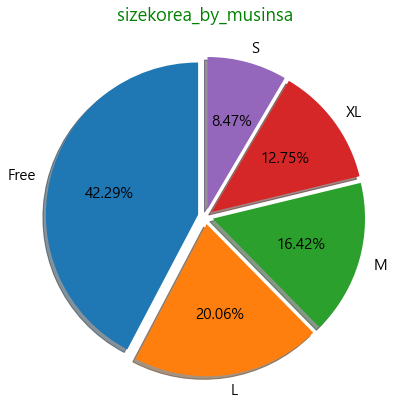

In [180]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(dt_shoulder_2020['size'].value_counts(), labels=('Free', 'L', 'M', 'XL', 'S'), startangle=90, autopct='%.2f%%',
        explode=[0.05, 0.05, 0.05, 0.05, 0.05], shadow=True, pctdistance=0.6)

# 라벨, 타이틀 달기
plt.title('sizekorea_by_musinsa', fontsize=18, color='g')

#plt.legend(['XS', 'M', 'S', 'XL', 'Free', 'L'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('sizekorea_chest_cm.jpg')
#plt.savefig('sizekorea_chest_cm.png')

## 9) 분류1 - 랜덤 포레스트
사이즈 코리아 데이터 - train(0.8), 검증데이터(0.2)<br>
무신사 사이즈 데이터 - test<br>

사이즈 코리아 데이터로 학습/예측을 먼저 진행하여 적합한 분류 모델을 찾고,<br>
그것을 바탕으로 무신사 사이즈 데이터를 학습하여 레이블을 예측한다

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [210]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [207]:
#예측 성능 평가 함수
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class="ovo")

    print('오차행렬')
    print()
    print(confusion)
    print()
    print(f'정확도 : {accuracy}, 정밀도 : {precision}, 재현율 : {recall}, F1 : {f1}, AUC : {roc_auc}')

In [212]:
def get_clf_eval1(y_test, pred = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    
    print(f'정확도 : {accuracy.round(4)}, 정밀도 : {precision.round(4)}, 재현율 : {recall.round(4)}, F1 : {f1.round(4)}')

### ①-1. 사이즈 코리아 데이터 (gmm_cluster = 5)

In [185]:
#dt_2020_gm5 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm5.csv").iloc[:, 1:]
dt_2020_gm5

,어깨너비,가슴단면,엉덩이단면,gmm_cluster=5,size(n=5)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,S
2,39.5,41.95,44.70,4,M
3,36.6,43.35,46.40,0,Free
4,37.7,45.10,45.45,0,Free
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,S
2663,40.0,39.45,43.35,1,S
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,3,L


In [186]:
dt_2020_gm5.drop('size(n=5)', axis=1, inplace=True)
dt_2020_gm5

,어깨너비,가슴단면,엉덩이단면,gmm_cluster=5
0,38.6,49.65,49.90,2
1,37.5,40.90,46.10,1
2,39.5,41.95,44.70,4
3,36.6,43.35,46.40,0
4,37.7,45.10,45.45,0
...,...,...,...,...
2662,35.8,41.60,46.10,1
2663,40.0,39.45,43.35,1
2664,38.0,47.10,52.95,2
2665,40.5,43.40,49.40,3


In [187]:
dt_2020_gm5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   어깨너비           2667 non-null   float64
 1   가슴단면           2667 non-null   float64
 2   엉덩이단면          2667 non-null   float64
 3   gmm_cluster=5  2667 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 83.5 KB


#### train, test set 만들기
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [188]:
np.array([x for x in dt_2020_gm5.iloc[5, :-1]])

array([39.4 , 43.75, 45.65])

In [189]:
lst_2020_gm5 = []

for i in range(len(dt_2020_gm5)):
    lst1 = [x for x in dt_2020_gm5.iloc[i, :-1]]
    lst_2020_gm5.append(lst1)
    
lst_2020_gm5

[[38.6, 49.650000000000006, 49.900000000000006],
 [37.5, 40.900000000000006, 46.1],
 [39.5, 41.95, 44.7],
 [36.6, 43.35, 46.400000000000006],
 [37.7, 45.1, 45.45],
 [39.400000000000006, 43.75, 45.650000000000006],
 [38.2, 40.150000000000006, 42.5],
 [38.800000000000004, 43.6, 46.150000000000006],
 [40.7, 42.1, 45.900000000000006],
 [37.6, 43.800000000000004, 46.0],
 [39.5, 45.35, 50.0],
 [35.6, 41.25, 41.6],
 [39.2, 46.050000000000004, 47.7],
 [42.400000000000006, 50.85, 51.800000000000004],
 [37.5, 41.550000000000004, 44.150000000000006],
 [40.6, 40.95, 43.45],
 [38.5, 41.75, 43.7],
 [38.7, 45.400000000000006, 47.7],
 [40.6, 47.650000000000006, 51.95],
 [42.0, 49.25, 53.6],
 [38.5, 45.650000000000006, 46.25],
 [40.5, 44.95, 48.400000000000006],
 [41.400000000000006, 41.6, 46.400000000000006],
 [40.1, 46.050000000000004, 49.900000000000006],
 [40.6, 40.0, 43.25],
 [43.7, 45.2, 46.0],
 [38.800000000000004, 42.7, 49.650000000000006],
 [39.7, 44.800000000000004, 51.050000000000004],
 [43.

In [190]:
train_2020_gm5 = np.array(lst_2020_gm5)
train_2020_gm5

array([[38.6 , 49.65, 49.9 ],
       [37.5 , 40.9 , 46.1 ],
       [39.5 , 41.95, 44.7 ],
       ...,
       [38.  , 47.1 , 52.95],
       [40.5 , 43.4 , 49.4 ],
       [39.4 , 44.5 , 47.6 ]])

In [191]:
test_2020_gm5 = np.array([x for x in dt_2020_gm5.iloc[:, -1]])
test_2020_gm5

array([2, 1, 4, ..., 2, 3, 0])

### ①-2. 랜덤 포레스트 실행 (gmm_cluster = 5)

In [192]:
X_features_5 = train_2020_gm5
y_label_5 = test_2020_gm5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5, test_size=0.2, random_state=0)

rf_clf = RandomForestClassifier(random_state=0, max_depth=10)
rf_clf.fit(X_train_5, y_train_5)

rf_clf_pred5 = rf_clf.predict(X_test_5)

accuracy_score(y_test_5, rf_clf_pred5).round(4)

0.9607

#### 하이퍼 파라미터 튜닝 GridSearchCV

In [193]:
from sklearn.model_selection import GridSearchCV

In [194]:
params = {
    'max_depth' : [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_5, y_train_5)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score: 0.9433


In [195]:
params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [2,6,8,10,16]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_5, y_train_5)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_split': 2}
best_score: 0.9503


In [196]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12, 16, 20],
           'min_samples_leaf' : [2, 6, 8, 12, 18],
           'min_samples_split' : [2, 6, 8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_5, y_train_5)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
best_score: 0.9494


In [140]:
cv_results_df5 = pd.DataFrame(grid_cv.cv_results_)
cv_results_df5[['param_max_depth', 'param_min_samples_split', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)[:5]

,param_max_depth,param_min_samples_split,mean_test_score
151,12,2,0.908891
251,20,2,0.908890
201,16,2,0.908439
253,20,6,0.908437
203,16,6,0.907536


In [197]:
rf_clf1 = RandomForestClassifier(max_depth=16, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train_5, y_train_5)

rf_clf1_pred5 = rf_clf1.predict(X_test_5)
accuracy_score(y_test_5, rf_clf1_pred5).round(4)

0.9551

### * 사이즈 코리아 데이터 (gmm_cluster = 5) 로 무신사 사이즈 데이터 예측

In [199]:
#test : 무신사 사이즈 데이터
dress_brands = pd.read_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_100_columns3.csv").iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [200]:
dress_brands['measures'].value_counts()

어깨너비     1806
가슴단면     1806
엉덩이단면    1806
Name: measures, dtype: int64

#### train set 만들기 (무신사 사이즈 데이터)
총장, 어깨너비, 가슴단면, 소매길이, 엉덩이단면<br>
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [202]:
shoulder_length = dress_brands[dress_brands['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = dress_brands[dress_brands['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

hip_length = dress_brands[dress_brands['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]

musinsa_feature_list = []

for i in range(len(shoulder_length)):
    li = [shoulder_li[i], chest_li[i],hip_li[i]]
    musinsa_feature_list.append(li)
    
X_features_musinsa = np.array(musinsa_feature_list)
X_features_musinsa

array([[33. , 43.5, 45. ],
       [34. , 46. , 47. ],
       [35. , 48.5, 49. ],
       ...,
       [33. , 43.5, 45. ],
       [34. , 46. , 47. ],
       [35. , 48.5, 49. ]])

In [203]:
#DataFrame 형태로도 만들기
musinsa_dress = pd.DataFrame({'어깨너비' : shoulder_li, '가슴단면' : chest_li, '엉덩이단면' : hip_li})
musinsa_dress

,어깨너비,가슴단면,엉덩이단면
0,33.0,43.5,45.0
1,34.0,46.0,47.0
2,35.0,48.5,49.0
3,50.0,40.0,44.0
4,51.0,41.0,45.0
...,...,...,...
1801,34.0,46.0,47.0
1802,35.0,48.5,49.0
1803,33.0,43.5,45.0
1804,34.0,46.0,47.0


In [204]:
X_features_5 = train_2020_gm5
y_label_5 = test_2020_gm5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5, test_size=0.2, random_state=0)

rf_clf1 = RandomForestClassifier(max_depth=16, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train_5, y_train_5)

rf_clf1_pred5_sz = rf_clf1.predict(X_test_5)    #사이즈 코리아 데이터의 test set 으로 예측 1번
rf_clf1_pred5_ms = rf_clf1.predict(X_features_musinsa)    #무신사 사이즈 데이터로 예측 2번

print(accuracy_score(y_test_5, rf_clf1_pred5_sz).round(4))
print()
print(rf_clf1_pred5_ms)

0.9551

[0 0 0 ... 0 0 0]


In [213]:
get_clf_eval1(y_test_5, rf_clf1_pred5_sz)

정확도 : 0.9551, 정밀도 : 0.9594, 재현율 : 0.9545, F1 : 0.9563


In [82]:
dt_2020_gm4.drop('size(4)', axis=1, inplace=True)
dt_2020_gm4

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=4
0,168.5,38.6,49.65,44.25,49.90,3
1,160.2,37.5,40.90,35.90,46.10,0
2,164.2,39.5,41.95,35.55,44.70,0
3,158.9,36.6,43.35,36.85,46.40,0
4,153.1,37.7,45.10,40.80,45.45,2
...,...,...,...,...,...,...
2767,159.7,35.8,41.60,35.95,46.10,0
2768,154.8,40.0,39.45,33.95,43.35,0
2769,164.5,38.0,47.10,41.45,52.95,3
2770,163.5,40.5,43.40,37.70,49.40,3


In [83]:
dt_2020_gm4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   키              2772 non-null   float64
 1   어깨너비           2772 non-null   float64
 2   가슴단면           2772 non-null   float64
 3   허리단면           2772 non-null   float64
 4   엉덩이단면          2772 non-null   float64
 5   gmm_cluster=4  2772 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 130.1 KB


#### train, test set 만들기
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [84]:
np.array([x for x in dt_2020_gm4.iloc[5, :-1]])

array([153.8 ,  39.4 ,  43.75,  38.5 ,  45.65])

In [85]:
lst_2020_gm4 = []

for i in range(len(dt_2020_gm4)):
    lst1 = [x for x in dt_2020_gm4.iloc[i, :-1]]
    lst_2020_gm4.append(lst1)
    
lst_2020_gm4

[[168.5, 38.6, 49.650000000000006, 44.25, 49.900000000000006],
 [160.20000000000002, 37.5, 40.900000000000006, 35.9, 46.1],
 [164.20000000000002, 39.5, 41.95, 35.550000000000004, 44.7],
 [158.9, 36.6, 43.35, 36.85, 46.400000000000006],
 [153.1, 37.7, 45.1, 40.8, 45.45],
 [153.8, 39.400000000000006, 43.75, 38.5, 45.650000000000006],
 [163.20000000000002, 38.2, 40.150000000000006, 35.4, 42.5],
 [165.10000000000002, 38.8, 43.6, 39.95, 46.150000000000006],
 [174.5, 40.7, 42.1, 34.2, 45.900000000000006],
 [153.20000000000002, 37.6, 43.8, 40.400000000000006, 46.0],
 [158.4, 39.5, 45.35, 43.150000000000006, 50.0],
 [158.10000000000002, 35.6, 41.25, 32.7, 41.6],
 [156.5, 39.2, 46.05, 42.1, 47.7],
 [167.20000000000002, 42.400000000000006, 50.85, 44.6, 51.8],
 [157.8, 37.5, 41.55, 34.9, 44.150000000000006],
 [156.10000000000002, 40.6, 40.95, 34.0, 43.45],
 [163.10000000000002, 38.5, 41.75, 32.050000000000004, 43.7],
 [161.20000000000002, 38.7, 45.400000000000006, 39.55, 47.7],
 [161.700000000000

In [86]:
train_2020_gm4 = np.array(lst_2020_gm4)
train_2020_gm4

array([[168.5 ,  38.6 ,  49.65,  44.25,  49.9 ],
       [160.2 ,  37.5 ,  40.9 ,  35.9 ,  46.1 ],
       [164.2 ,  39.5 ,  41.95,  35.55,  44.7 ],
       ...,
       [164.5 ,  38.  ,  47.1 ,  41.45,  52.95],
       [163.5 ,  40.5 ,  43.4 ,  37.7 ,  49.4 ],
       [153.5 ,  39.4 ,  44.5 ,  42.95,  47.6 ]])

In [87]:
test_2020_gm4 = np.array([x for x in dt_2020_gm4.iloc[:, -1]])
test_2020_gm4

array([3, 0, 0, ..., 3, 3, 2])

In [154]:
X_features_4 = train_2020_gm4
y_label_4 = test_2020_gm4

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_features_4, y_label_4, test_size=0.2, random_state=0)

rf_clf = RandomForestClassifier(random_state=0, max_depth=10)
rf_clf.fit(X_train_4, y_train_4)

rf_clf_pred4 = rf_clf.predict(X_test_4)
accuracy_score(y_test_4, rf_clf_pred4).round(4)

0.9351

#### 하이퍼 파라미터 튜닝 GridSearchCV

In [155]:
params = {
    'max_depth' : [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_4, y_train_4)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score: 0.9332


In [156]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12, 16, 20],
           'min_samples_leaf' : [2, 6, 8, 12, 18],
           'min_samples_split' : [2, 6, 8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_4, y_train_4)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
best_score: 0.9396


In [157]:
params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [2,6,8,10,16]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_4, y_train_4)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 12, 'min_samples_split': 2}
best_score: 0.9405


In [158]:
cv_results_df4 = pd.DataFrame(grid_cv.cv_results_)
cv_results_df4[['param_max_depth', 'param_min_samples_split', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)[:5]

,param_max_depth,param_min_samples_split,mean_test_score
15,12,2,0.940461
20,16,2,0.939110
30,24,2,0.939109
25,20,2,0.939109
16,12,6,0.937305


In [88]:
X_features_4 = train_2020_gm4
y_label_4 = test_2020_gm4

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_features_4, y_label_4, test_size=0.2, random_state=0)

In [89]:
rf_clf1 = RandomForestClassifier(max_depth=12, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train_4, y_train_4)
rf_clf1_pred4 = rf_clf1.predict(X_test_4)
accuracy_score(y_test_4, rf_clf1_pred4).round(4)

0.9477

In [91]:
#test : 무신사 사이즈 데이터
dress_brands = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/dress_brands_100.csv").iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,109.0,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57.0,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
9025,114.0,m,총장,LIENLIER,로즈퍼프원피스 - 카키
9026,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
9027,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
9028,60.0,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [92]:
dress_brands['measures'].value_counts()

총장       1806
어깨너비     1806
가슴단면     1806
소매길이     1806
엉덩이단면    1806
Name: measures, dtype: int64

#### train set 만들기 (무신사 사이즈 데이터)
총장, 어깨너비, 가슴단면, 소매길이, 엉덩이단면<br>
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [93]:
total_length = dress_brands[dress_brands['measures'] == '총장']
length_li = [x for x in total_length['values']]

shoulder_length = dress_brands[dress_brands['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = dress_brands[dress_brands['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

arms_length = dress_brands[dress_brands['measures'] == '소매길이']
arms_li = [x for x in arms_length['values']]

#waist_length = dress_brands[dress_brands['measures'] == '허리단면']
#waist_li = [x for x in waist_length['values']]

hip_length = dress_brands[dress_brands['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]

musinsa_feature_list = []

for i in range(len(total_length)):
    li = [length_li[i], shoulder_li[i], chest_li[i], arms_li[i], hip_li[i]]
    musinsa_feature_list.append(li)
    
X_features_musinsa = np.array(musinsa_feature_list)
X_features_musinsa

array([[109. ,  33. ,  43.5,  57. ,  45. ],
       [111. ,  34. ,  46. ,  58. ,  47. ],
       [114. ,  35. ,  48.5,  60. ,  49. ],
       ...,
       [109. ,  33. ,  43.5,  57. ,  45. ],
       [111. ,  34. ,  46. ,  58. ,  47. ],
       [114. ,  35. ,  48.5,  60. ,  49. ]])

In [94]:
#DataFrame 형태로도 만들기
musinsa_dress = pd.DataFrame({'총장' : length_li, '어깨너비' : shoulder_li,
                              '가슴단면' : chest_li, '소매길이' : arms_li, '엉덩이단면' : hip_li})
musinsa_dress

,총장,어깨너비,가슴단면,소매길이,엉덩이단면
0,109.0,33.0,43.5,57.0,45.0
1,111.0,34.0,46.0,58.0,47.0
2,114.0,35.0,48.5,60.0,49.0
3,85.0,50.0,40.0,53.0,44.0
4,87.0,51.0,41.0,54.0,45.0
...,...,...,...,...,...
1801,111.0,34.0,46.0,58.0,47.0
1802,114.0,35.0,48.5,60.0,49.0
1803,109.0,33.0,43.5,57.0,45.0
1804,111.0,34.0,46.0,58.0,47.0


In [95]:
X_features = train_2020_gm4
y_label = test_2020_gm4

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=0)

rf_clf1 = RandomForestClassifier(max_depth=12, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)

rf_clf1_pred_sz = rf_clf1.predict(X_test)    #사이즈 코리아 데이터의 test set 으로 예측 1번
rf_clf1_pred_ms = rf_clf1.predict(X_features_musinsa)    #무신사 사이즈 데이터로 예측 2번

print(accuracy_score(y_test, rf_clf1_pred_sz).round(4))
print()
print(rf_clf1_pred_ms)

0.9477

[2 2 2 ... 2 2 2]


In [99]:
def get_clf_eval1(y_test, pred = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    
    print(f'정확도 : {accuracy.round(4)}, 정밀도 : {precision.round(4)}, 재현율 : {recall.round(4)}, F1 : {f1.round(4)}')

In [100]:
get_clf_eval1(y_test, rf_clf1_pred_sz)

정확도 : 0.9477, 정밀도 : 0.9479, 재현율 : 0.9469, F1 : 0.9473


In [23]:
dt_2020_km4 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_km4.csv").iloc[:, 1:]
dt_2020_km4

,키,어깨너비,가슴단면,허리단면,엉덩이단면,cluster=4,size(4)
0,168.5,38.6,49.65,44.25,49.90,1,XL
1,160.2,37.5,40.90,35.90,46.10,0,S
2,164.2,39.5,41.95,35.55,44.70,3,L
3,158.9,36.6,43.35,36.85,46.40,0,S
4,153.1,37.7,45.10,40.80,45.45,2,M
...,...,...,...,...,...,...,...
2767,159.7,35.8,41.60,35.95,46.10,0,S
2768,154.8,40.0,39.45,33.95,43.35,0,S
2769,164.5,38.0,47.10,41.45,52.95,1,XL
2770,163.5,40.5,43.40,37.70,49.40,3,L


In [24]:
dt_2020_km4.drop('size(4)', axis=1, inplace=True)
dt_2020_km4

,키,어깨너비,가슴단면,허리단면,엉덩이단면,cluster=4
0,168.5,38.6,49.65,44.25,49.90,1
1,160.2,37.5,40.90,35.90,46.10,0
2,164.2,39.5,41.95,35.55,44.70,3
3,158.9,36.6,43.35,36.85,46.40,0
4,153.1,37.7,45.10,40.80,45.45,2
...,...,...,...,...,...,...
2767,159.7,35.8,41.60,35.95,46.10,0
2768,154.8,40.0,39.45,33.95,43.35,0
2769,164.5,38.0,47.10,41.45,52.95,1
2770,163.5,40.5,43.40,37.70,49.40,3


In [25]:
dt_2020_km4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   키          2772 non-null   float64
 1   어깨너비       2772 non-null   float64
 2   가슴단면       2772 non-null   float64
 3   허리단면       2772 non-null   float64
 4   엉덩이단면      2772 non-null   float64
 5   cluster=4  2772 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 130.1 KB


#### train, test set 만들기
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [26]:
np.array([x for x in dt_2020_km4.iloc[5, :-1]])

array([153.8 ,  39.4 ,  43.75,  38.5 ,  45.65])

In [27]:
lst_2020_km4 = []

for i in range(len(dt_2020_km4)):
    lst1 = [x for x in dt_2020_km4.iloc[i, :-1]]
    lst_2020_km4.append(lst1)
    
lst_2020_km4

[[168.5, 38.6, 49.650000000000006, 44.25, 49.900000000000006],
 [160.20000000000002, 37.5, 40.900000000000006, 35.9, 46.1],
 [164.20000000000002, 39.5, 41.95, 35.550000000000004, 44.7],
 [158.9, 36.6, 43.35, 36.85, 46.400000000000006],
 [153.1, 37.7, 45.1, 40.8, 45.45],
 [153.8, 39.400000000000006, 43.75, 38.5, 45.650000000000006],
 [163.20000000000002, 38.2, 40.150000000000006, 35.4, 42.5],
 [165.10000000000002, 38.8, 43.6, 39.95, 46.150000000000006],
 [174.5, 40.7, 42.1, 34.2, 45.900000000000006],
 [153.20000000000002, 37.6, 43.8, 40.400000000000006, 46.0],
 [158.4, 39.5, 45.35, 43.150000000000006, 50.0],
 [158.10000000000002, 35.6, 41.25, 32.7, 41.6],
 [156.5, 39.2, 46.05, 42.1, 47.7],
 [167.20000000000002, 42.400000000000006, 50.85, 44.6, 51.8],
 [157.8, 37.5, 41.55, 34.9, 44.150000000000006],
 [156.10000000000002, 40.6, 40.95, 34.0, 43.45],
 [163.10000000000002, 38.5, 41.75, 32.050000000000004, 43.7],
 [161.20000000000002, 38.7, 45.400000000000006, 39.55, 47.7],
 [161.700000000000

In [28]:
train_2020_km4 = np.array(lst_2020_km4)
train_2020_km4

array([[168.5 ,  38.6 ,  49.65,  44.25,  49.9 ],
       [160.2 ,  37.5 ,  40.9 ,  35.9 ,  46.1 ],
       [164.2 ,  39.5 ,  41.95,  35.55,  44.7 ],
       ...,
       [164.5 ,  38.  ,  47.1 ,  41.45,  52.95],
       [163.5 ,  40.5 ,  43.4 ,  37.7 ,  49.4 ],
       [153.5 ,  39.4 ,  44.5 ,  42.95,  47.6 ]])

In [29]:
test_2020_km4 = np.array([x for x in dt_2020_km4.iloc[:, -1]])
test_2020_km4

array([1, 0, 3, ..., 1, 3, 2])

#### train, test set 만들기
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [145]:
np.array([x for x in dt_2020_km4_edit.iloc[5, :-1]])

array([39.4 , 43.75, 45.65])

In [146]:
lst_2020_km4 = []

for i in range(len(dt_2020_km4_edit)):
    lst1 = [x for x in dt_2020_km4_edit.iloc[i, :-1]]
    lst_2020_km4.append(lst1)
    
lst_2020_km4

[[38.6, 49.650000000000006, 49.900000000000006],
 [37.5, 40.900000000000006, 46.1],
 [39.5, 41.95, 44.7],
 [36.6, 43.35, 46.400000000000006],
 [37.7, 45.1, 45.45],
 [39.400000000000006, 43.75, 45.650000000000006],
 [38.2, 40.150000000000006, 42.5],
 [38.8, 43.6, 46.150000000000006],
 [40.7, 42.1, 45.900000000000006],
 [37.6, 43.8, 46.0],
 [39.5, 45.35, 50.0],
 [35.6, 41.25, 41.6],
 [39.2, 46.05, 47.7],
 [42.400000000000006, 50.85, 51.8],
 [37.5, 41.55, 44.150000000000006],
 [40.6, 40.95, 43.45],
 [38.5, 41.75, 43.7],
 [38.7, 45.400000000000006, 47.7],
 [40.6, 47.650000000000006, 51.95],
 [42.0, 49.25, 53.6],
 [38.5, 45.650000000000006, 46.25],
 [40.5, 44.95, 48.400000000000006],
 [41.400000000000006, 41.6, 46.400000000000006],
 [40.1, 46.05, 49.900000000000006],
 [40.6, 40.0, 43.25],
 [43.7, 45.2, 46.0],
 [38.8, 42.7, 49.650000000000006],
 [39.7, 44.8, 51.05],
 [43.6, 47.25, 49.150000000000006],
 [42.5, 41.2, 44.650000000000006],
 [38.3, 42.75, 43.95],
 [45.400000000000006, 48.45, 51.0

In [147]:
train_2020_km4 = np.array(lst_2020_km4)
train_2020_km4

array([[38.6 , 49.65, 49.9 ],
       [37.5 , 40.9 , 46.1 ],
       [39.5 , 41.95, 44.7 ],
       ...,
       [38.  , 47.1 , 52.95],
       [40.5 , 43.4 , 49.4 ],
       [39.4 , 44.5 , 47.6 ]])

In [149]:
test_2020_km4 = np.array([x for x in dt_2020_km4_edit.iloc[:, -1]])
test_2020_km4

array([1, 0, 3, ..., 1, 3, 2])

In [150]:
#X_features_4, y_label_4, train, test set 는 XGBoost 때와 동일
X_features_4 = train_2020_km4
y_label_4 = test_2020_km4

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_features_4, y_label_4,
                                                            test_size=0.1, random_state=0)

X_tr_4, X_val_4, y_tr_4, y_val_4 = train_test_split(X_train_4, y_train_4,
                                                    test_size=0.36, random_state=0)

print(X_train_4.shape, X_test_4.shape)
print(X_tr_4.shape, X_val_4.shape)

(2494, 3) (278, 3)
(1596, 3) (898, 3)


In [30]:
X_features_4 = train_2020_km4
y_label_4 = test_2020_km4

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_features_4, y_label_4, test_size=0.2, random_state=0)

rf_clf = RandomForestClassifier(random_state=0, max_depth=10)
rf_clf.fit(X_train_4, y_train_4)

rf_clf_pred4 = rf_clf.predict(X_test_4)
accuracy_score(y_test_4, rf_clf_pred4).round(4)

0.964

#### 하이퍼 파라미터 튜닝 GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
params = {
    'max_depth' : [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_4, y_train_4)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score: 0.9359


In [34]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12, 16, 20],
           'min_samples_leaf' : [2, 6, 8, 12, 18],
           'min_samples_split' : [2, 6, 8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_4, y_train_4)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
best_score: 0.9486


In [35]:
params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [2,6,8,10,16]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_4, y_train_4)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_split': 6}
best_score: 0.9504


In [36]:
cv_results_df4 = pd.DataFrame(grid_cv.cv_results_)
cv_results_df4[['param_max_depth', 'param_min_samples_split', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)[:5]

,param_max_depth,param_min_samples_split,mean_test_score
26,20,6,0.950381
21,16,6,0.950381
31,24,6,0.950381
20,16,2,0.949931
16,12,6,0.949480


In [ ]:
X_features_4 = train_2020_km4
y_label_4 = test_2020_km4

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_features_4, y_label_4, test_size=0.2, random_state=0)

In [37]:
rf_clf1 = RandomForestClassifier(max_depth = 16, min_samples_split = 6, random_state=0)

rf_clf1.fit(X_train_4, y_train_4)

rf_clf1_pred4 = rf_clf1.predict(X_test_4)

accuracy_score(y_test_4, rf_clf1_pred4).round(4)

0.955

In [38]:
#test : 무신사 사이즈 데이터
dress_brands = pd.read_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_100.csv").iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,109.0,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57.0,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
9025,114.0,m,총장,LIENLIER,로즈퍼프원피스 - 카키
9026,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
9027,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
9028,60.0,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [39]:
dress_brands['measures'].value_counts()

총장       1806
어깨너비     1806
가슴단면     1806
소매길이     1806
엉덩이단면    1806
Name: measures, dtype: int64

#### train set 만들기 (무신사 사이즈 데이터)
총장, 어깨너비, 가슴단면, 소매길이, 엉덩이단면<br>
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [40]:
total_length = dress_brands[dress_brands['measures'] == '총장']
length_li = [x for x in total_length['values']]

shoulder_length = dress_brands[dress_brands['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = dress_brands[dress_brands['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

arms_length = dress_brands[dress_brands['measures'] == '소매길이']
arms_li = [x for x in arms_length['values']]

#waist_length = dress_brands[dress_brands['measures'] == '허리단면']
#waist_li = [x for x in waist_length['values']]

hip_length = dress_brands[dress_brands['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]

musinsa_feature_list = []

for i in range(len(total_length)):
    li = [length_li[i], shoulder_li[i], chest_li[i], arms_li[i], hip_li[i]]
    musinsa_feature_list.append(li)
    
X_features_musinsa = np.array(musinsa_feature_list)
X_features_musinsa

array([[109. ,  33. ,  43.5,  57. ,  45. ],
       [111. ,  34. ,  46. ,  58. ,  47. ],
       [114. ,  35. ,  48.5,  60. ,  49. ],
       ...,
       [109. ,  33. ,  43.5,  57. ,  45. ],
       [111. ,  34. ,  46. ,  58. ,  47. ],
       [114. ,  35. ,  48.5,  60. ,  49. ]])

In [41]:
#DataFrame 형태로도 만들기
musinsa_dress = pd.DataFrame({'총장' : length_li, '어깨너비' : shoulder_li,
                              '가슴단면' : chest_li, '소매길이' : arms_li, '엉덩이단면' : hip_li})
musinsa_dress

,총장,어깨너비,가슴단면,소매길이,엉덩이단면
0,109.0,33.0,43.5,57.0,45.0
1,111.0,34.0,46.0,58.0,47.0
2,114.0,35.0,48.5,60.0,49.0
3,85.0,50.0,40.0,53.0,44.0
4,87.0,51.0,41.0,54.0,45.0
...,...,...,...,...,...
1801,111.0,34.0,46.0,58.0,47.0
1802,114.0,35.0,48.5,60.0,49.0
1803,109.0,33.0,43.5,57.0,45.0
1804,111.0,34.0,46.0,58.0,47.0


In [83]:
musinsa_dress.values

array([[109. ,  33. ,  43.5,  57. ,  45. ],
       [111. ,  34. ,  46. ,  58. ,  47. ],
       [114. ,  35. ,  48.5,  60. ,  49. ],
       ...,
       [109. ,  33. ,  43.5,  57. ,  45. ],
       [111. ,  34. ,  46. ,  58. ,  47. ],
       [114. ,  35. ,  48.5,  60. ,  49. ]])

In [42]:
X_features = train_2020_km4
y_label = test_2020_km4

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=0)

rf_clf1 = RandomForestClassifier(max_depth = 16, min_samples_split = 6, random_state=0)

rf_clf1.fit(X_train, y_train)

rf_clf1_pred_sz = rf_clf1.predict(X_test)    #사이즈 코리아 데이터의 test set 으로 예측 1번
rf_clf1_pred_ms = rf_clf1.predict(X_features_musinsa)    #무신사 사이즈 데이터로 예측 2번

print(accuracy_score(y_test, rf_clf1_pred_sz).round(4))
print()
print(rf_clf1_pred_ms)

0.955

[2 2 2 ... 2 2 2]


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [46]:
def get_clf_eval1(y_test, pred = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    
    print(f'정확도 : {accuracy.round(4)}, 정밀도 : {precision.round(4)}, 재현율 : {recall.round(4)}, F1 : {f1.round(4)}')

In [47]:
get_clf_eval1(y_test, rf_clf1_pred_sz)

정확도 : 0.955, 정밀도 : 0.9574, 재현율 : 0.9512, F1 : 0.9539


### ②-1. 사이즈 코리아 데이터 (km_cluster = 5)

In [215]:
dt_2020_km5

,어깨너비,가슴단면,엉덩이단면,cluster=5,size(n=5)
0,38.6,49.65,49.90,0,XL
1,37.5,40.90,46.10,4,S
2,39.5,41.95,44.70,4,S
3,36.6,43.35,46.40,3,M
4,37.7,45.10,45.45,3,M
...,...,...,...,...,...
2662,35.8,41.60,46.10,3,M
2663,40.0,39.45,43.35,4,S
2664,38.0,47.10,52.95,0,XL
2665,40.5,43.40,49.40,2,L


In [216]:
dt_2020_km5.drop('size(n=5)', axis=1, inplace=True)
dt_2020_km5

,어깨너비,가슴단면,엉덩이단면,cluster=5
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,4
2,39.5,41.95,44.70,4
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,3
2663,40.0,39.45,43.35,4
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,2


In [217]:
dt_2020_km5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   어깨너비       2667 non-null   float64
 1   가슴단면       2667 non-null   float64
 2   엉덩이단면      2667 non-null   float64
 3   cluster=5  2667 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 73.1 KB


#### train, test set 만들기
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [218]:
np.array([x for x in dt_2020_km5.iloc[3, :-1]])

array([36.6 , 43.35, 46.4 ])

In [219]:
lst_2020_km5 = []

for i in range(len(dt_2020_km5)):
    lst1 = [x for x in dt_2020_km5.iloc[i, :-1]]
    lst_2020_km5.append(lst1)
    
lst_2020_km5

[[38.6, 49.650000000000006, 49.900000000000006],
 [37.5, 40.900000000000006, 46.1],
 [39.5, 41.95, 44.7],
 [36.6, 43.35, 46.400000000000006],
 [37.7, 45.1, 45.45],
 [39.400000000000006, 43.75, 45.650000000000006],
 [38.2, 40.150000000000006, 42.5],
 [38.800000000000004, 43.6, 46.150000000000006],
 [40.7, 42.1, 45.900000000000006],
 [37.6, 43.800000000000004, 46.0],
 [39.5, 45.35, 50.0],
 [35.6, 41.25, 41.6],
 [39.2, 46.050000000000004, 47.7],
 [42.400000000000006, 50.85, 51.800000000000004],
 [37.5, 41.550000000000004, 44.150000000000006],
 [40.6, 40.95, 43.45],
 [38.5, 41.75, 43.7],
 [38.7, 45.400000000000006, 47.7],
 [40.6, 47.650000000000006, 51.95],
 [42.0, 49.25, 53.6],
 [38.5, 45.650000000000006, 46.25],
 [40.5, 44.95, 48.400000000000006],
 [41.400000000000006, 41.6, 46.400000000000006],
 [40.1, 46.050000000000004, 49.900000000000006],
 [40.6, 40.0, 43.25],
 [43.7, 45.2, 46.0],
 [38.800000000000004, 42.7, 49.650000000000006],
 [39.7, 44.800000000000004, 51.050000000000004],
 [43.

In [220]:
train_2020_km5 = np.array(lst_2020_km5)
train_2020_km5

array([[38.6 , 49.65, 49.9 ],
       [37.5 , 40.9 , 46.1 ],
       [39.5 , 41.95, 44.7 ],
       ...,
       [38.  , 47.1 , 52.95],
       [40.5 , 43.4 , 49.4 ],
       [39.4 , 44.5 , 47.6 ]])

In [221]:
test_2020_km5 = np.array([x for x in dt_2020_km5.iloc[:, -1]])
test_2020_km5

array([0, 4, 4, ..., 0, 2, 2])

### ③-2. 랜덤 포레스트 실행 (km_cluster = 5)

In [222]:
X_features_5 = train_2020_km5
y_label_5 = test_2020_km5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5, test_size=0.2, random_state=0)

rf_clf = RandomForestClassifier(random_state=0, max_depth=10)
rf_clf.fit(X_train_5, y_train_5)

rf_clf_pred5 = rf_clf.predict(X_test_5)
accuracy_score(y_test_5, rf_clf_pred5).round(4)

0.9532

#### 하이퍼 파라미터 튜닝 GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV

In [223]:
params = {
    'max_depth' : [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_5, y_train_5)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score: 0.9386


In [224]:
params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [2,6,8,10,16]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_5, y_train_5)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_split': 8}
best_score: 0.9433


In [225]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12, 16, 20],
           'min_samples_leaf' : [2, 6, 8, 12, 18],
           'min_samples_split' : [2, 6, 8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_5, y_train_5)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
best_score: 0.9428


In [36]:
cv_results_df5 = pd.DataFrame(grid_cv.cv_results_)
cv_results_df5[['param_max_depth', 'param_min_samples_split', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)[:5]

,param_max_depth,param_min_samples_split,mean_test_score
26,20,6,0.950381
21,16,6,0.950381
31,24,6,0.950381
20,16,2,0.949931
16,12,6,0.949480


In [227]:
X_features_5 = train_2020_km5
y_label_5 = test_2020_km5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5, test_size=0.2, random_state=0)

In [228]:
rf_clf1 = RandomForestClassifier(max_depth=16, min_samples_split=8, random_state=0)

rf_clf1.fit(X_train_5, y_train_5)

rf_clf1_pred5 = rf_clf1.predict(X_test_5)

accuracy_score(y_test_5, rf_clf1_pred5).round(4)

0.9551

### * 사이즈 코리아 데이터 (km_cluster = 5) 로 무신사 사이즈 데이터 예측

train set = dt_2020_km5<br>
test set = dress_brands

In [229]:
#test : 무신사 사이즈 데이터
dress_brands = pd.read_csv("C:/Users/admin/#실습(221031~221111)/dress_brands_100_columns3.csv").iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [230]:
dress_brands['measures'].value_counts()

어깨너비     1806
가슴단면     1806
엉덩이단면    1806
Name: measures, dtype: int64

#### train set 만들기 (무신사 사이즈 데이터)
총장, 어깨너비, 가슴단면, 소매길이, 엉덩이단면<br>
np.array([x for x in dt_2020_gm6.iloc[0, :-1]])<br>
np.concatenate([arr1, arr2])<br>
np.stack((arr_2020_gm6, arr1), axis=0)

In [231]:
X_features_musinsa

array([[33. , 43.5, 45. ],
       [34. , 46. , 47. ],
       [35. , 48.5, 49. ],
       ...,
       [33. , 43.5, 45. ],
       [34. , 46. , 47. ],
       [35. , 48.5, 49. ]])

In [232]:
musinsa_dress

,어깨너비,가슴단면,엉덩이단면
0,33.0,43.5,45.0
1,34.0,46.0,47.0
2,35.0,48.5,49.0
3,50.0,40.0,44.0
4,51.0,41.0,45.0
...,...,...,...
1801,34.0,46.0,47.0
1802,35.0,48.5,49.0
1803,33.0,43.5,45.0
1804,34.0,46.0,47.0


In [233]:
X_features_5 = train_2020_km5
y_label_5 = test_2020_km5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5, test_size=0.2, random_state=0)

rf_clf1 = RandomForestClassifier(max_depth=16, min_samples_split=8, random_state=0)

rf_clf1.fit(X_train_5, y_train_5)

rf_clf1_pred5_sz = rf_clf1.predict(X_test_5)    #사이즈 코리아 데이터의 test set 으로 예측 1번
rf_clf1_pred5_ms = rf_clf1.predict(X_features_musinsa)    #무신사 사이즈 데이터로 예측 2번

print(accuracy_score(y_test_5, rf_clf1_pred5_sz).round(4))
print()
print(rf_clf1_pred5_ms)

0.9551

[3 3 3 ... 3 3 3]


In [234]:
get_clf_eval1(y_test_5, rf_clf1_pred5_sz)

정확도 : 0.9551, 정밀도 : 0.9581, 재현율 : 0.9515, F1 : 0.9543


## 10) 분류2 - XGBoost

In [235]:
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb

In [236]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [237]:
#예측 성능 평가 함수
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class="ovo")

    print('오차행렬')
    print()
    print(confusion)
    print()
    print(f'정확도 : {accuracy}, 정밀도 : {precision}, 재현율 : {recall}, F1 : {f1}, AUC : {roc_auc}')

### * gmm_cluster = 5
train_2020_gm5, test_2020_gm5

In [238]:
X_features_5 = train_2020_gm5
y_label_5 = test_2020_gm5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5,
                                                            test_size=0.1, random_state=0)

X_tr_5, X_val_5, y_tr_5, y_val_5 = train_test_split(X_train_5, y_train_5,
                                                    test_size=0.36, random_state=0)

print(X_train_5.shape, X_test_5.shape)
print(X_tr_5.shape, X_val_5.shape)

(2400, 3) (267, 3)
(1536, 3) (864, 3)


#### 하이퍼 파라미터 튜닝 HyperOpt

In [239]:
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials
from sklearn.model_selection import cross_val_score

In [240]:
# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1 사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 20, 1),
                   'min_child_weight' : hp.quniform('min_child_weight', 1, 2, 1),
                   'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
                   'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1)}

In [241]:
#fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형이다
#XGBClassifier의 하이퍼 파라미터는 정수형 변환을 해주어야 한다
#정확도는 높을수록 더 좋은 수치이므로, 정확도*(-1)를 해서 큰 정확도 값일수록 최소가 되도록 한다

def objective_func_5(search_space):
    #수행시간 절약을 위해 n_estimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           learning_rate=search_space['learning_rate'],
                           colsample_bytree=search_space['colsample_bytree'],
                           eval_metric='logloss')
    
    accuracy = cross_val_score(xgb_clf, X_train_5, y_train_5, scoring='accuracy', cv=3)
    
    #accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되, -1을 곱함
    return {'loss' : -1*np.mean(accuracy), 'status' : STATUS_OK}

In [242]:
#최적 하이퍼 파라미터 출력
trial_val = Trials()

best = fmin(fn=objective_func_5, space=xgb_search_space,
            algo=tpe.suggest, max_evals=50,
           trials=trial_val, rstate=np.random.default_rng(seed=9))

print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/trial, best loss: -0.9420833333333333]
best: {'colsample_bytree': 0.9909028221918748, 'learning_rate': 0.1996445307166108, 'max_depth': 5.0, 'min_child_weight': 1.0}


In [243]:
print(f"colsample_bytree : {round(best['colsample_bytree'], 5)}, learning_rate : {round(best['learning_rate'], 5)}, min_child_weight : {int(best['min_child_weight'])}, max_depth : {int(best['max_depth'])}")

colsample_bytree : 0.9909, learning_rate : 0.19964, min_child_weight : 1, max_depth : 5


In [244]:
musinsa_dress

,어깨너비,가슴단면,엉덩이단면
0,33.0,43.5,45.0
1,34.0,46.0,47.0
2,35.0,48.5,49.0
3,50.0,40.0,44.0
4,51.0,41.0,45.0
...,...,...,...
1801,34.0,46.0,47.0
1802,35.0,48.5,49.0
1803,33.0,43.5,45.0
1804,34.0,46.0,47.0


데이터 건수가 많은 경우 원본 학습 데이터를 다시 학습과 검증 데이터로 분리하고 여기에 조기 중단 회수를 적절하게 부여할 경우 과적합을 개선할 수 있다

In [245]:
xgb_wrapper = XGBClassifier(n_estimators = 400,
                           learning_rate = round(best['learning_rate'], 5),
                           max_depth = int(best['max_depth']),
                           min_child_weight = int(best['min_child_weight']),
                           colsample_bytree = round(best['colsample_bytree'], 5))

evals = [(X_tr_5, y_tr_5), (X_val_5, y_val_5)]

xgb_wrapper.fit(X_tr_5, y_tr_5, early_stopping_rounds=50, eval_metric='mlogloss',
                eval_set=evals, verbose=True)

xgb_val_preds1 = xgb_wrapper.predict(X_test_5)
xgb_val_preds2 = xgb_wrapper.predict(musinsa_dress.values)

xgb_val_pred_proba = xgb_wrapper.predict_proba(X_test_5)[:, 1]

xgb_val_preds2

[0]	validation_0-mlogloss:1.33138	validation_1-mlogloss:1.35810
[1]	validation_0-mlogloss:1.15440	validation_1-mlogloss:1.20225
[2]	validation_0-mlogloss:0.98267	validation_1-mlogloss:1.04882
[3]	validation_0-mlogloss:0.84734	validation_1-mlogloss:0.92241
[4]	validation_0-mlogloss:0.75214	validation_1-mlogloss:0.83366
[5]	validation_0-mlogloss:0.66437	validation_1-mlogloss:0.75399
[6]	validation_0-mlogloss:0.58790	validation_1-mlogloss:0.68275
[7]	validation_0-mlogloss:0.51856	validation_1-mlogloss:0.61877
[8]	validation_0-mlogloss:0.46923	validation_1-mlogloss:0.57248
[9]	validation_0-mlogloss:0.42149	validation_1-mlogloss:0.52934
[10]	validation_0-mlogloss:0.38152	validation_1-mlogloss:0.49340
[11]	validation_0-mlogloss:0.35259	validation_1-mlogloss:0.46638
[12]	validation_0-mlogloss:0.32421	validation_1-mlogloss:0.43880
[13]	validation_0-mlogloss:0.30101	validation_1-mlogloss:0.41640
[14]	validation_0-mlogloss:0.27679	validation_1-mlogloss:0.39541
[15]	validation_0-mlogloss:0.25352	

array([1, 0, 2, ..., 1, 0, 2])

In [246]:
def get_clf_eval1(y_test, pred = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    
    print(f'정확도 : {accuracy.round(4)}, 정밀도 : {precision.round(4)}, 재현율 : {recall.round(4)}, F1 : {f1.round(4)}')

In [247]:
get_clf_eval1(y_test_5, xgb_val_preds1)

정확도 : 0.9551, 정밀도 : 0.9581, 재현율 : 0.9532, F1 : 0.955


## 11) 분류3 - LightGBM

In [249]:
from lightgbm import LGBMClassifier

### * gmm_cluster = 5
train_2020_gm5, test_2020_gm5

In [250]:
#X_features_6, y_label_6, train, test set 는 XGBoost 때와 동일
X_features_5 = train_2020_gm5
y_label_5 = test_2020_gm5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5,
                                                            test_size=0.1, random_state=0)

X_tr_5, X_val_5, y_tr_5, y_val_5 = train_test_split(X_train_5, y_train_5,
                                                    test_size=0.36, random_state=0)

print(X_train_5.shape, X_test_5.shape)
print(X_tr_5.shape, X_val_5.shape)

(2400, 3) (267, 3)
(1536, 3) (864, 3)


In [251]:
#하이퍼 파라미터
lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves', 32, 64, 1),
                    'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                    'min_child_samples' : hp.quniform('min_child_samples', 60, 100, 1),
                    'subsample' : hp.uniform('subsample', 0.7, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)}

In [252]:
# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 반환

def objective_func_5(search_space):
    
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    lgbm_clf = LGBMClassifier(n_estimators = 100,
                             num_leaves = int(search_space['num_leaves']),
                             max_depth = int(search_space['max_depth']),
                             min_child_samples = int(search_space['min_child_samples']),
                             subsample = search_space['subsample'],
                             learning_rate = search_space['learning_rate'])
    accuracy = cross_val_score(lgbm_clf, X_train_5, y_train_5, scoring = 'accuracy', cv = 3)
    
    return {'loss': -1 * np.mean(accuracy), 'status' : STATUS_OK}

In [253]:
trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func_5,
            space = lgbm_search_space,
            algo = tpe.suggest, max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30))

print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97trial/s, best loss: -0.9508333333333333]
best: {'learning_rate': 0.1507676855953287, 'max_depth': 144.0, 'min_child_samples': 93.0, 'num_leaves': 41.0, 'subsample': 0.7224091022706465}


In [254]:
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves = int(best['num_leaves']),
                         max_depth = int(best['max_depth']),
                         min_child_samples = int(best['min_child_samples']),
                         subsample = round(best['subsample'], 5),
                         learning_rate = round(best['learning_rate'], 5))

# evaulation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
lgbm_clf.fit(X_tr_5, y_tr_5, early_stopping_rounds = 100, eval_metric = 'multi_logloss',
             eval_set = [(X_tr_5, y_tr_5), (X_val_5, y_val_5)])

preds1 = lgbm_clf.predict(X_test_5)
preds2_5 = lgbm_clf.predict(musinsa_dress.values)

get_clf_eval1(y_test_5, preds1)

[1]	training's multi_logloss: 1.24066	valid_1's multi_logloss: 1.26398
Training until validation scores don't improve for 100 rounds
[2]	training's multi_logloss: 1.0157	valid_1's multi_logloss: 1.0397
[3]	training's multi_logloss: 0.855022	valid_1's multi_logloss: 0.885087
[4]	training's multi_logloss: 0.738353	valid_1's multi_logloss: 0.771198
[5]	training's multi_logloss: 0.646971	valid_1's multi_logloss: 0.682514
[6]	training's multi_logloss: 0.572841	valid_1's multi_logloss: 0.612818
[7]	training's multi_logloss: 0.510631	valid_1's multi_logloss: 0.550345
[8]	training's multi_logloss: 0.454585	valid_1's multi_logloss: 0.497063
[9]	training's multi_logloss: 0.406968	valid_1's multi_logloss: 0.453397
[10]	training's multi_logloss: 0.362744	valid_1's multi_logloss: 0.41313
[11]	training's multi_logloss: 0.332393	valid_1's multi_logloss: 0.383638
[12]	training's multi_logloss: 0.300996	valid_1's multi_logloss: 0.351779
[13]	training's multi_logloss: 0.274414	valid_1's multi_logloss: 0

In [277]:
X_test_5[:4]

array([[39.8 , 48.2 , 50.4 ],
       [38.3 , 43.  , 44.75],
       [40.  , 51.15, 52.35],
       [39.1 , 44.3 , 46.5 ]])

In [278]:
musinsa_dress.values

array([[33. , 43.5, 45. ],
       [34. , 46. , 47. ],
       [35. , 48.5, 49. ],
       ...,
       [33. , 43.5, 45. ],
       [34. , 46. , 47. ],
       [35. , 48.5, 49. ]])

### * 결과

랜덤포레스트(gmm 5)
정확도 : 0.9551, 정밀도 : 0.9594, 재현율 : 0.9545, F1 : 0.9563

랜덤포레스트(km 5)
정확도 : 0.9551, 정밀도 : 0.9581, 재현율 : 0.9515, F1 : 0.9543

XGBoost(gmm 5)
정확도 : 0.9551, 정밀도 : 0.9581, 재현율 : 0.9532, F1 : 0.955

LightGBM(gmm 5)
정확도 : 0.9625, 정밀도 : 0.9646, 재현율 : 0.9614, F1 : 0.9628

## 12) 추천 시스템 생성
dress_brands / rf_clf1_pred_ms / X_features_musinsa / musinsa_dress

### * 무신사 사이즈 데이터프레임 정리 (1)

In [255]:
dress_brands

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [256]:
dress_brands['measures'].value_counts()

어깨너비     1806
가슴단면     1806
엉덩이단면    1806
Name: measures, dtype: int64

In [257]:
brand_li = []
product_li = []
size_li = []


for i in range(0, 5418, 3):
    brand_data = dress_brands['brand_name'][i]
    brand_li.append(brand_data)
    
    product_data = dress_brands['product_name'][i]
    product_li.append(product_data)
    
    size_data = dress_brands['size'][i]
    size_li.append(size_data)

print(len(brand_li), len(product_li), len(size_li))

1806 1806 1806


In [258]:
shoulder_length = dress_brands[dress_brands['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = dress_brands[dress_brands['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

hip_length = dress_brands[dress_brands['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]

In [259]:
musinsa_dress_list = []

for i in range(len(shoulder_length)):
    li = [brand_li[i], product_li[i], size_li[i], shoulder_li[i], chest_li[i], hip_li[i]]
    musinsa_dress_list.append(li)
    
musinsa_dress_df = pd.DataFrame({'brand_name' : brand_li, 'product_name' : product_li, 'size' : size_li,
                                 '어깨너비' : shoulder_li, '가슴단면' : chest_li, '엉덩이단면' : hip_li})

musinsa_dress_df

,brand_name,product_name,size,어깨너비,가슴단면,엉덩이단면
0,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0
1,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0
2,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0
3,AVANDRESS,Minimal Slim Dress BLACK,S,50.0,40.0,44.0
4,AVANDRESS,Minimal Slim Dress BLACK,M,51.0,41.0,45.0
...,...,...,...,...,...,...
1801,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0
1802,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0
1803,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0
1804,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0


### * 무신사 사이즈 데이터프레임 정리 (2)

In [260]:
dress_brands[:15]

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
6,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
7,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
8,49.0,m,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
9,50.0,S,어깨너비,AVANDRESS,Minimal Slim Dress BLACK


In [261]:
shoulder_length = dress_brands[dress_brands['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = dress_brands[dress_brands['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

hip_length = dress_brands[dress_brands['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]


musinsa_feature_list = []

for i in range(len(shoulder_length)):
    li = [shoulder_li[i], chest_li[i], hip_li[i]]
    musinsa_feature_list.append(li)
    
musinsa_feature_list

[[33.0, 43.5, 45.0],
 [34.0, 46.0, 47.0],
 [35.0, 48.5, 49.0],
 [50.0, 40.0, 44.0],
 [51.0, 41.0, 45.0],
 [50.0, 40.0, 44.0],
 [51.0, 41.0, 45.0],
 [35.5, 41.0, 38.0],
 [35.5, 41.0, 38.0],
 [51.0, 41.0, 53.5],
 [51.0, 41.0, 53.5],
 [44.5, 48.0, 49.0],
 [33.0, 43.5, 45.0],
 [34.0, 46.0, 47.0],
 [35.0, 48.5, 49.0],
 [35.5, 41.0, 38.0],
 [38.5, 45.5, 47.5],
 [40.0, 48.0, 50.0],
 [59.0, 59.0, 58.0],
 [39.0, 39.0, 41.0],
 [41.5, 40.0, 43.5],
 [50.0, 40.0, 44.0],
 [51.0, 41.0, 45.0],
 [38.0, 40.5, 50.0],
 [33.0, 43.5, 45.0],
 [34.0, 46.0, 47.0],
 [35.0, 48.5, 49.0],
 [39.5, 43.0, 49.5],
 [40.5, 45.5, 52.0],
 [44.0, 55.0, 110.0],
 [38.0, 42.5, 64.0],
 [39.0, 45.0, 66.5],
 [40.0, 47.5, 69.0],
 [41.0, 50.0, 71.5],
 [50.0, 40.0, 44.0],
 [51.0, 41.0, 45.0],
 [59.0, 65.0, 66.0],
 [37.5, 38.0, 32.0],
 [33.0, 43.5, 45.0],
 [34.0, 46.0, 47.0],
 [35.0, 48.5, 49.0],
 [25.0, 46.0, 100.0],
 [46.0, 46.0, 64.0],
 [47.0, 48.5, 66.5],
 [48.0, 51.0, 69.0],
 [49.0, 53.5, 71.5],
 [48.0, 52.0, 58.0],
 [42.0, 42.

In [262]:
brand_product_size_lst = []

for i in range(0, 5418, 3):
    lst = [dress_brands['brand_name'][i], dress_brands['product_name'][i], dress_brands['size'][i]]    
    brand_product_size_lst.append(lst)

brand_product_size_lst

[['LIENLIER', '로즈퍼프원피스 - 카키', 'xs'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 's'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 'm'],
 ['AVANDRESS', 'Minimal Slim Dress BLACK', 'S'],
 ['AVANDRESS', 'Minimal Slim Dress BLACK', 'M'],
 ['AVANDRESS', 'Minimal Slim Dress IVORY', 'S'],
 ['AVANDRESS', 'Minimal Slim Dress IVORY', 'M'],
 ['AVANDRESS', 'Diagonal Slim Dress BLACK', 'FREE'],
 ['AVANDRESS', 'Diagonal Slim Dress GREY', 'FREE'],
 ['AVANDRESS', 'SHINE SLIM ONEPIECE SKY', 'S'],
 ['AVANDRESS', 'SHINE SLIM ONEPIECE SKY', 'M'],
 ['YYIAM', 'YY silken dark black waist gather dress', 'FREE'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 'xs'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 's'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 'm'],
 ['AVANDRESS', 'Diagonal Slim Dress KHAKI', 'FREE'],
 ['AMBLER', 'Twinlook bear 코튼 카라 미니 원피스  AOPS201 (black)', 'S'],
 ['AMBLER', 'Twinlook bear 코튼 카라 미니 원피스  AOPS201 (black)', 'M'],
 ['BETWEEN A AND B', '후드 롱져지 기모 원피스 [버건디]', '프리사이즈'],
 ['NOT YOUR ROSE', '소피아 드레스 (블랙)', 'S'],
 ['NOT YOUR ROSE', '소피아 드레스 (블랙)', 'M'],
 ['

In [263]:
musinsa_dress_df2 = pd.DataFrame({'brand_product_size' : brand_product_size_lst,
                                 'musinsa_feature' : musinsa_feature_list})

musinsa_dress_df2

,brand_product_size,musinsa_feature
0,"[LIENLIER, 로즈퍼프원피스 - 카키, xs]","[33.0, 43.5, 45.0]"
1,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]"
2,"[LIENLIER, 로즈퍼프원피스 - 카키, m]","[35.0, 48.5, 49.0]"
3,"[AVANDRESS, Minimal Slim Dress BLACK, S]","[50.0, 40.0, 44.0]"
4,"[AVANDRESS, Minimal Slim Dress BLACK, M]","[51.0, 41.0, 45.0]"
...,...,...
1801,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]"
1802,"[LIENLIER, 로즈퍼프원피스 - 카키, m]","[35.0, 48.5, 49.0]"
1803,"[LIENLIER, 로즈퍼프원피스 - 카키, xs]","[33.0, 43.5, 45.0]"
1804,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]"


#### LightGBM

In [264]:
preds2_5

array([0, 0, 2, ..., 0, 0, 2])

In [265]:
preds2_5.shape
type(preds2_5)

numpy.ndarray

In [266]:
np.unique(preds2_5, return_counts=True)

(array([0, 1, 2, 3, 4]), array([646, 153, 840,  90,  77], dtype=int64))

In [267]:
preds2_5.reshape(-1,1)

array([[0],
       [0],
       [2],
       ...,
       [0],
       [0],
       [2]])

In [268]:
musinsa_dress_df2['size_pattern'] = preds2_5.reshape(-1,1)
musinsa_dress_df2

,brand_product_size,musinsa_feature,size_pattern
0,"[LIENLIER, 로즈퍼프원피스 - 카키, xs]","[33.0, 43.5, 45.0]",0
1,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]",0
2,"[LIENLIER, 로즈퍼프원피스 - 카키, m]","[35.0, 48.5, 49.0]",2
3,"[AVANDRESS, Minimal Slim Dress BLACK, S]","[50.0, 40.0, 44.0]",4
4,"[AVANDRESS, Minimal Slim Dress BLACK, M]","[51.0, 41.0, 45.0]",4
...,...,...,...
1801,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]",0
1802,"[LIENLIER, 로즈퍼프원피스 - 카키, m]","[35.0, 48.5, 49.0]",2
1803,"[LIENLIER, 로즈퍼프원피스 - 카키, xs]","[33.0, 43.5, 45.0]",0
1804,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]",0


In [269]:
preds2_5_lst = preds2_5.tolist()
preds2_5_lst

[0,
 0,
 2,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 1,
 4,
 4,
 4,
 4,
 0,
 0,
 2,
 3,
 3,
 2,
 0,
 3,
 2,
 2,
 4,
 4,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 4,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 4,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 2,
 0,
 0,
 2,
 3,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 4,
 3,
 4,
 3,
 2,
 0,
 2,
 1,
 3,
 2,
 4,
 1,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 1,
 3,
 3,
 0,
 0,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 4,
 3,
 2,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 3,
 2,
 0,


In [270]:
np.unique(preds2_5, return_counts=True)

(array([0, 1, 2, 3, 4]), array([646, 153, 840,  90,  77], dtype=int64))

In [271]:
musinsa_dress_df2['size_pattern'].value_counts()

2    840
0    646
1    153
3     90
4     77
Name: size_pattern, dtype: int64

#### 0 -> Free / 1 -> S / 2 -> XL / 3 -> L / 4 -> M

In [279]:
musinsa_dress_df['size(n=5)'] = np.random.randint(1806)
size_li = []

for i in range(1806):
    if musinsa_dress_df2['size_pattern'][i] == 0:
        size_li.append('Free')
        
    elif musinsa_dress_df2['size_pattern'][i] == 1:
        size_li.append('S')
        
    elif musinsa_dress_df2['size_pattern'][i] == 2:
        size_li.append('XL')
        
    elif musinsa_dress_df2['size_pattern'][i] == 3:
        size_li.append('L')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

musinsa_dress_df['size(n=5)'] = size_li

musinsa_dress_df

,brand_name,product_name,size,어깨너비,가슴단면,엉덩이단면,size(n=5)
0,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0,Free
1,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0,Free
2,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0,XL
3,AVANDRESS,Minimal Slim Dress BLACK,S,50.0,40.0,44.0,M
4,AVANDRESS,Minimal Slim Dress BLACK,M,51.0,41.0,45.0,M
...,...,...,...,...,...,...,...
1801,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0,Free
1802,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0,XL
1803,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0,Free
1804,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0,Free


In [280]:
musinsa_dress_df['size(n=5)'].value_counts()

XL      840
Free    646
S       153
L        90
M        77
Name: size(n=5), dtype: int64

In [281]:
musinsa_dress_df.groupby('size(n=5)')[['size(n=5)']].count()

,size(n=5)
size(n=5),
Free,646
L,90
M,77
S,153
XL,840


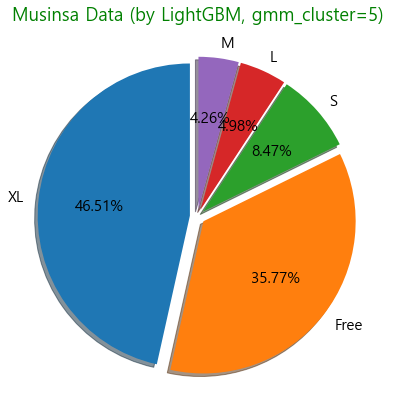

In [282]:
#무신사 데이터 분류 결과
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(musinsa_dress_df['size(n=5)'].value_counts(), labels=('XL', 'Free', 'S', 'L', 'M'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('Musinsa Data (by LightGBM, gmm_cluster=5)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(cluster=4).png')
#plt.savefig('SizeKorea_Data(cluster=4).jpg')

### ① 각 치수 별 오차 구하기

In [88]:
musinsa_dress_df

,brand_name,product_name,size,총장,어깨너비,가슴단면,소매길이,엉덩이단면
0,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK,F,89.5,37.5,41.5,62.5,46.0
1,AVANDRESS,Minimal Slim Dress BLACK,S,85.0,50.0,40.0,53.0,44.0
2,AVANDRESS,Minimal Slim Dress BLACK,M,87.0,51.0,41.0,54.0,45.0
3,AVANDRESS,Minimal Slim Dress IVORY,S,85.0,50.0,40.0,53.0,44.0
4,AVANDRESS,Minimal Slim Dress IVORY,M,87.0,51.0,41.0,54.0,45.0
...,...,...,...,...,...,...,...,...
435,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK,F,89.5,37.5,41.5,62.5,46.0
436,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK,F,89.5,37.5,41.5,62.5,46.0
437,LOYALDECIDE,플리츠 원피스,Free,95.0,40.0,49.0,62.0,68.0
438,REORG,DRO SQUARE NECK TWO PLEATS OPS BLACK,F,89.5,37.5,41.5,62.5,46.0


In [90]:
dt_2020_gm4 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm4.csv").iloc[:, 1:]
dt_2020_gm4

,키,어깨너비,가슴단면,허리단면,엉덩이단면,gmm_cluster=4,size(4)
0,168.5,38.6,49.65,44.25,49.90,1,L
1,164.2,39.5,41.95,35.55,44.70,3,S
2,158.9,36.6,43.35,36.85,46.40,3,S
3,153.1,37.7,45.10,40.80,45.45,0,M
4,153.8,39.4,43.75,38.50,45.65,0,M
...,...,...,...,...,...,...,...
2766,159.7,35.8,41.60,35.95,46.10,3,S
2767,154.8,40.0,39.45,33.95,43.35,3,S
2768,164.5,38.0,47.10,41.45,52.95,1,L
2769,163.5,40.5,43.40,37.70,49.40,1,L


dt_2020_gm4['어깨너비'] - musinsa_dress_df['어깨너비']<br>
dt_2020_gm4['가슴단면'] - musinsa_dress_df['가슴단면']<br>
dt_2020_gm4['엉덩이단면'] - musinsa_dress_df['엉덩이단면']

In [191]:
error_sum_lst = []

for i in range(6):
    for j in range(3):
        shoulder_error = abs( dt_2020_gm4['어깨너비'][i] - musinsa_dress_df['어깨너비'][j] )
        chest_error = abs( dt_2020_gm4['가슴단면'][i] - musinsa_dress_df['가슴단면'][j] )
        hip_error = abs( dt_2020_gm4['엉덩이단면'][i] - musinsa_dress_df['엉덩이단면'][j] )
        
        error_sum = [shoulder_error.round(2) + chest_error.round(2) + hip_error.round(2)]
        error_sum_lst.append(error_sum)

error_sum_lst

[[16.65],
 [11.15],
 [5.65],
 [8.350000000000001],
 [11.850000000000001],
 [15.350000000000001],
 [5.15],
 [5.85],
 [9.35],
 [6.750000000000001],
 [6.15],
 [9.649999999999999],
 [7.300000000000001],
 [9.0],
 [12.5],
 [11.05],
 [14.55],
 [18.05]]

### ② 분류 결과를 바탕으로 추천

#### * 모델 예상 (1)
사이즈 코리아 데이터의 분류된 사이즈와, 무신사 데이터의 분류된 사이즈가 같은 경우가 많은 브랜드와 상품 top10 추천

In [226]:
#사이즈가 같은 것의 브랜드명과 상품명 추출
same_size_name_df = musinsa_dress_df.copy()

for i in range(1806):
    if dt_2020_gm4['size(4)'][i] != musinsa_dress_df['size_clf'][i]:
        same_size_name_df.drop(index=[i], inplace=True)
    else:
        continue
        
same_size_name_df

,brand_name,product_name,size,총장,어깨너비,가슴단면,소매길이,엉덩이단면,size_clf
1,LIENLIER,로즈퍼프원피스 - 카키,s,111.0,34.0,46.0,58.0,47.0,S
5,AVANDRESS,Minimal Slim Dress IVORY,S,85.0,50.0,40.0,53.0,44.0,S
9,AVANDRESS,SHINE SLIM ONEPIECE SKY,S,85.0,51.0,41.0,45.0,53.5,M
13,LIENLIER,로즈퍼프원피스 - 카키,s,111.0,34.0,46.0,58.0,47.0,S
15,AVANDRESS,Diagonal Slim Dress KHAKI,FREE,79.0,35.5,41.0,57.0,38.0,S
...,...,...,...,...,...,...,...,...,...
1789,LIENLIER,로즈퍼프원피스 - 카키,s,111.0,34.0,46.0,58.0,47.0,S
1793,LIENLIER,로즈퍼프원피스 - 카키,m,114.0,35.0,48.5,60.0,49.0,M
1796,LIENLIER,로즈퍼프원피스 - 카키,m,114.0,35.0,48.5,60.0,49.0,M
1801,LIENLIER,로즈퍼프원피스 - 카키,s,111.0,34.0,46.0,58.0,47.0,S


In [229]:
same_size_name_df['brand_name'].value_counts()[:10]

LIENLIER           109
JUCYJUDY            35
ESPRIT              19
BROOKS BROTHERS     19
TINABLOSSOM         16
DUNDROP             15
LANGNLU             13
WE'DEE               9
JULIY&CALLA          9
JMARKNEWYORK         9
Name: brand_name, dtype: int64

In [233]:
same_size_name_df[same_size_name_df['brand_name'] == 'LIENLIER']['product_name'].value_counts()

로즈퍼프원피스 - 카키    104
셔츠 원피스 - 네이비      3
셔츠 원피스 - 베이지      2
Name: product_name, dtype: int64

In [236]:
same_size_name_df[same_size_name_df['brand_name'] == 'JUCYJUDY']['product_name'].value_counts()[:5]

J셔츠형턱주름원피스 JWOP426W          2
J슬림핏허리트임원피스 JWOP325F         2
J컬러블록반팔져지원피스 JWOP526A        2
J콜라보프린트언발네크프릴원피스 JWOP426N    2
J하이넥벨티드원피스 JWOP721O          2
Name: product_name, dtype: int64

In [237]:
same_size_name_df[same_size_name_df['brand_name'] == 'ESPRIT']['product_name'].value_counts()[:5]

Dolphin Tennis Club 클래식 폴로 원피스 레드     5
Dolphin Tennis Club 플리츠 폴로 원피스 핑크     3
Dolphin Tennis Club 클래식 폴로 원피스 블랙     3
Dolphin Tennis Club 플리츠 폴로 원피스 화이트    2
Dolphin Tennis Club 클래식 폴로 원피스 네이비    2
Name: product_name, dtype: int64

In [239]:
same_size_name_df[same_size_name_df['brand_name'] == 'BROOKS BROTHERS']['product_name'].value_counts()[:5]

소프트 롱 슬리브 드레스 (화이트) 75994364           4
코튼 플란넬 롱-슬리브 셔츠 드레스 (레드) (75994121)    3
스트레치 코튼 풀오버 드레스 (블랙) 75994320          3
코튼 프레피 펀 스트라이프 셔츠 드레스 66792396         3
코튼 풀라드 프린트 셔츠 드레스 75993937             2
Name: product_name, dtype: int64

#### * 모델 예상 (2)

In [130]:
### 사이즈 코리아 피실험자 임의로 한 명 설정
sample_ID = 983

### 사이즈 코리아 군집화 기반 사이즈 분류 확인
sample = dt_2020_km4.iloc[sample_ID, :]
sample_size = sample[5]

### 피실험자의 사이즈에 해당하는 제품을 갖고 있는 브랜드 top 5 추출
### Musinsa Standard의 데이터 수가 너무 많아서 제외함
brand_got_sizes = musinsa_dress_df[musinsa_dress_df['size_pattern'] == sample_size]
top5_brands = brand_got_sizes.groupby('brand_name')[['product_name']].count().sort_values('product_name', ascending = False)[1:6]
top5_brands

,product_name
brand_name,
JUCYJUDY,62
DUNDROP,38
ESPRIT,38
BROOKS BROTHERS,34
SIMPLE RETRO,32


In [131]:
sample

키            159.00
어깨너비          38.40
가슴단면          45.90
허리단면          40.25
엉덩이단면         45.95
cluster=4      2.00
Name: 983, dtype: float64

In [132]:
sample_size

2.0

In [133]:
sample_size_li = [sample[1], sample[2], sample[4]]
sample_size_li[2]

45.95

In [134]:
musinsa_dress_df[musinsa_dress_df['size_pattern'] == sample_size]

,brand_name,product_name,size,총장,어깨너비,가슴단면,소매길이,엉덩이단면,size_pattern
0,LIENLIER,로즈퍼프원피스 - 카키,xs,109.0,33.0,43.5,57.0,45.0,2
1,LIENLIER,로즈퍼프원피스 - 카키,s,111.0,34.0,46.0,58.0,47.0,2
2,LIENLIER,로즈퍼프원피스 - 카키,m,114.0,35.0,48.5,60.0,49.0,2
3,AVANDRESS,Minimal Slim Dress BLACK,S,85.0,50.0,40.0,53.0,44.0,2
4,AVANDRESS,Minimal Slim Dress BLACK,M,87.0,51.0,41.0,54.0,45.0,2
...,...,...,...,...,...,...,...,...,...
1801,LIENLIER,로즈퍼프원피스 - 카키,s,111.0,34.0,46.0,58.0,47.0,2
1802,LIENLIER,로즈퍼프원피스 - 카키,m,114.0,35.0,48.5,60.0,49.0,2
1803,LIENLIER,로즈퍼프원피스 - 카키,xs,109.0,33.0,43.5,57.0,45.0,2
1804,LIENLIER,로즈퍼프원피스 - 카키,s,111.0,34.0,46.0,58.0,47.0,2


In [135]:
### 피실험자의 신체 치수 추출 후 무신사 제품 치수 순서대로 배열
## 어깨너비, 가슴단면, 엉덩이단면 치수만
sample_size_li = [sample[1], sample[2], sample[4]]

### 피실험자의 사이즈에 해당하는 제품들 중 오차가 가장 적은 제품을 추천
## 같은 사이즈 제품 추출
same_size_products = musinsa_dress_df[musinsa_dress_df['size_pattern'] == sample_size]
same_size_products = same_size_products.reset_index().iloc[:, 1:]

## 각 제품들의 치수 오차 계산
es = []

for i in range(len(same_size_products)):
    e = 0
    
    e = e + abs(sample_size_li[0] - same_size_products['어깨너비'][i]) + \
    abs(sample_size_li[1] - same_size_products['가슴단면'][i]) + \
    abs(sample_size_li[2] - same_size_products['엉덩이단면'][i])
    
    es.append(e)

## 무신사 데이터에 오차 계산값 추가 후 
## 오차들의 합이 가장 적은 순서대로 정렬
## top 50 상품명 추출
same_size_products['difference'] = es

ordered_products = same_size_products.sort_values('difference')
ordered_products.loc[:, ['product_name', 'difference']][:50]

,product_name,difference
91,로우 버튼 카라 OP (PN3WO962),1.350
937,하이넥 고어드 스커트 롱 드레스 블랙,1.550
519,Boet Pad Dress_BLACK,1.550
672,하이넥 고어드 스커트 롱 드레스 핑크,1.550
516,Boet Pad Dress_PINK,1.550
373,Present collar dress (Pink),1.850
994,Present collar dress (Black),1.850
769,벨트 크링클 코튼 블렌드 오버사이즈 셔츠 드레스 (블랙),2.050
768,벨트 크링클 코튼 블렌드 오버사이즈 셔츠 드레스 (아이보리),2.050
16,Twinlook bear 코튼 카라 미니 원피스 AOPS201 (black),2.050


In [ ]:
size_korea_df = dt_2020_gm5.copy()

### ③ 상품 추천 함수 생성

In [138]:
def brands_for_you(ID):
    ### 고객 ID 입력
    customer_ID = ID

    ### 사이즈 코리아 군집화 기반 사이즈 분류 확인
    customer_size = size_korea_df.iloc[customer_ID, :][?]

    ### 피실험자의 사이즈에 해당하는 제품을 갖고 있는 브랜드 top 5 추출
    ### Musinsa Standard의 데이터 수가 너무 많아서 제외함
    brand_got_sizes = musinsa_dress_df[musinsa_dress_df['size_pattern'] == customer_size]
    top5_brands = brand_got_sizes.groupby('brand_name')[['product_name']].count().sort_values('product_name', ascending = False)[1:6]
    TOP5 = [x for x in top5_brands.index]
    
    return TOP5

In [ ]:
def products_for_you(ID)   :
    ### 고객 ID 입력
    customer_ID = ID
    
    ### 사이즈 코리아 군집화 기반 사이즈 분류 확인
    customer = size_korea_df.iloc[customer_ID, :]
    customer_size = customer[-1]
    
    ### 피실험자의 신체 치수 추출 후 무신사 제품 치수 순서대로 배열
    customer_size_li = [customer[0], customer[1], customer[2]]

    ### 피실험자의 사이즈에 해당하는 제품들 중 오차가 가장 적은 제품을 추천
    ## 같은 사이즈 제품 추출
    same_size_products = musinsa_dress_df[musinsa_dress_df['size_pattern'] == customer_size]
    same_size_products = same_size_products.reset_index().iloc[:, 1:]

    ## 각 제품들의 치수 오차 계산
    es = []

    for i in range(len(same_size_products)):
        e = 0

        e = e + abs(customer_size_li[0] - same_size_products['어깨너비'][i]) + \
        abs(customer_size_li[1] - same_size_products['가슴단면'][i]) + \
        abs(customer_size_li[2] - same_size_products['엉덩이단면'][i])

        es.append(e)

    ## 무신사 데이터에 오차 계산값 추가 후 
    ## 오차들의 합이 가장 적은 순서대로 정렬
    ## top 50 상품명 추출
    same_size_products['difference'] = es

    ordered_products = same_size_products.sort_values('difference')
    top_products = ordered_products.loc[:, ['product_name', 'difference']][:50]
    TOP_PRODUCTS = top_products['product_name'].unique()
    
    return TOP_PRODUCTS

In [139]:
recommend_func(500)

                 product_name
brand_name                   
JUCYJUDY                   62
DUNDROP                    38
ESPRIT                     38
BROOKS BROTHERS            34
SIMPLE RETRO               32


,product_name,difference
639,2001 Dress,0.7
544,엠마 리본 버튼 원피스 [IVORY],2.3
542,엠마 리본 버튼 원피스 [BLACK],2.3
539,리나 셔링 원피스 [BLACK],2.8
537,리나 셔링 원피스 [IVORY],2.8
272,DRO SQUARE NECK TWO PLEATS OPS BLACK,3.2
885,MINI JACKET SET UP DRESS_BLACK,3.3
340,MINI JACKET SET UP DRESS_GREY,3.3
470,SHIRRING EASY DRESS (CHARCOAL),3.4
469,SHIRRING EASY DRESS (BROWN),3.4
